In [2]:
import tensorflow as tf

import os
import time
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Preparation

## Convert data files

### Read breakfast data

In [3]:
# read the dataset and some exploration

g = os.walk(r"/content/drive/MyDrive/FurtherStudy/Project2020/groundTruthlabel-breakfastdatset/")
# g is a generator with (path,dir_list,file_list)
# https://blog.csdn.net/mighty13/article/details/77995857

file_list = list(g)  # path,dir_list,file_list in g
path, _, file_list = file_list[0]

fps = 15
resolution = (320, 240)  # 320 * 240
# 52 different individuals, 18 different kitchens, 10 cooking activities
person = {}  
cams = {}  
activity = {} 
data_files = []  # txt data file names

for file_name in file_list:
  if file_name.endswith(".txt"):
    data_files.append(file_name)
    pts = file_name[:file_name.rfind('.')].split('_')
    person[pts[0]] = person[pts[0]] + 1 if pts[0] in person else 1
    cams[pts[1]] = cams[pts[1]] + 1 if pts[1] in cams else 1
    activity[pts[3]] = activity[pts[3]] + 1 if pts[3] in activity else 1

print("Individuals:", person)
print("Camera:", cams)
print("Activities:", activity)

Individuals: {'P51': 46, 'P30': 23, 'P43': 40, 'P14': 29, 'P07': 18, 'P36': 37, 'P13': 23, 'P29': 25, 'P32': 25, 'P23': 44, 'P37': 40, 'P49': 46, 'P27': 35, 'P35': 32, 'P41': 50, 'P20': 39, 'P21': 40, 'P04': 30, 'P17': 34, 'P24': 42, 'P52': 45, 'P16': 37, 'P18': 33, 'P53': 43, 'P42': 48, 'P46': 44, 'P31': 23, 'P47': 41, 'P26': 31, 'P38': 40, 'P22': 41, 'P19': 32, 'P12': 20, 'P39': 43, 'P11': 19, 'P54': 44, 'P15': 29, 'P25': 33, 'P28': 10, 'P05': 11, 'P33': 24, 'P44': 45, 'P48': 42, 'P50': 48, 'P34': 25, 'P40': 46, 'P03': 26, 'P45': 44, 'P06': 11, 'P08': 12, 'P09': 15, 'P10': 9}
Camera: {'webcam01': 365, 'cam02': 272, 'webcam02': 338, 'stereo01': 304, 'cam01': 433}
Activities: {'sandwich': 169, 'friedegg': 173, 'cereals': 184, 'scrambledegg': 166, 'pancake': 157, 'salat': 163, 'tea': 184, 'milk': 187, 'juice': 162, 'coffee': 167}


### video class

In [4]:
# Video Stream Class
class VideoStream:
  def __init__(self, stream=None):
    self.stream = stream
    self.total_frame = 0
    if stream is not None:
      for _, count in stream:
        self.total_frame += count


class VideoStream1(VideoStream):
  """Video stream as a list of action and frame count
  Designed for files like those txt files of the breakfast dataset
  """
  def __init__(self, path=None, file_name=None, fps=15, remove=["SIL"],stream=None):
    self.fps = fps  # frame rate of the original videos
    self.remove = remove
    self.file_name = file_name  
    super(VideoStream1, self).__init__(stream)
    if path is not None and file_name is not None:
      stream = []
      f = open(path+file_name, 'r')
      temp = ""
      count = 0
      for line in f.readlines():
        line = line.strip()
        if line == temp:
          count += 1
        elif line not in remove:
          if count > 0:
            stream.append((temp, count))
            self.total_frame += count
          temp = line
          count = 1
      if temp not in remove and count > 0:
        stream.append((temp, count))
        self.total_frame += count
      self.stream = stream  # a list of (action, frame count)
      f.close()

  @property
  def jsonName(self):
    """return json information from file name, including activity/purpose"""
    if self.file_name is None:
      return None
    file_name = self.file_name
    pts = file_name[:file_name.rfind('.')].split('_')
    return {"file_name":file_name, "person":pts[0], "camera":pts[1], "activity":pts[3]}

  def obs_by_frame_index(self, end, start=0):
    """return the observation stream between the two given index of frame
    [start, end)
    """
    obs = []
    remain_start = start
    remain_end = end
    for action, count in self.stream:
      if remain_end == 0:
        return obs
      if count <= remain_start:
        remain_start -= count
        remain_end -= count
      else:
        if remain_start > 0:
          count -= remain_start
          remain_end -= remain_start
          remain_start = 0
        if count > remain_end:
          obs.append((action, remain_end))
          return obs
        else:
          remain_end -= count
          obs.append((action, count))
    return obs

  def action_by_frame_index(self, index):
    """return the action at the given index of frame; return None if the index
    is too large to stay in range
    """
    remain = index
    action_index = 0
    for action, count in self.stream:
      if count > remain:
        return action, action_index
      else:
        remain -= count
        action_index += 1
    return None, len(self.stream)
    
  def label_obs(self, sps, ts):
    """ take the first sps part of the data as observations and label the action
     at t seconds after an observation ends

    split: partial percentage of a video as observation
    ts: sec after the observation that we interested

    return: json of observations and their labels
    """
    n = self.total_frame
    res = {}
    for p in sps:
      n_obs = int(np.round(n*p))
      obs = self.obs_by_frame_index(n_obs)
      action_label = []
      for t in ts:
        frame = n_obs + int(self.fps*t)
        action_label.append(self.action_by_frame_index(frame-1))
      res[p] = {"observation":obs, "tsec":ts, "action_labels":action_label}
    return res


class VideoStream2(VideoStream1):
  def label_obs(self, ts, step, window_size, unit_is_second=True):
    """use sliding window instead of ratio
    unit: second if unit_is_second==True else frame
    """
    fps = self.fps
    if unit_is_second:
      step *= fps
      window_size *= fps
    res = []
    n_obs = window_size
    while n_obs <= self.total_frame:
      start, end = n_obs-window_size, n_obs
      obs = self.obs_by_frame_index(start=start, end=end)
      last_action = self.action_by_frame_index(n_obs-1)
      action_label = []
      for t in ts:
        frame = n_obs + int(fps*t)
        action_label.append(self.action_by_frame_index(frame-1))
      res.append({"observation":obs, "obs_frame":(start, end), "last_action":last_action, "tsec":ts, "action_labels":action_label})
      n_obs += step
    return res

## First time running

### set up input pipeline

1. Reduce the observations into 1 fps and produce the features. 

In [ ]:
# action exploration for the Breakfast dataset
action_set = set()
for fileN in data_files:
  video = VideoStream2(path,fileN)
  for pairs in video.stream:
    if pairs[0] not in action_set:
      action_set.add(pairs[0])

print(action_set)
len(action_set)

In [ ]:
# encode and decode method for one-hot code of actions
action_lst = []
action_dict = {}
index = 0
for action in action_set:
  if action not in action_dict:
    action_lst.append(action)
    action_dict[action] = index
    index += 1
"""
def action_encode(action):
  onehot = np.zeros(len(action_set),dtype=int)
  if action in action_dict:
    onehot[action_dict[action]] = 1
  return onehot

def action_decode(onehot):
  for index in range(len(onehot)):
    if onehot[index] == 1:
      return action_lst[index]
  return None
"""
def action_encode(action):
  if action is not None and action in action_dict:
    return action_dict[action] + 1
  return 0

def action_decode(token):
  if token > 0 and token <= len(action_lst):
    return action_lst[token-1]
  return None

In [ ]:
q = 30
fps = 15
ts=[1, 3, 5, 7, 10, 20, 30, 40, 50, 60]
step = 10

In [ ]:
def build_features(obs):
  features = []
  remain = 0

  for action, frame_count in obs:
    if remain > 0:
      frame_count += remain - fps
      if remain < fps/2:
        features += [action_encode(action)]
    i = int(frame_count/fps)
    features += [action_encode(action)] * i
    remain = frame_count - i * fps
#    if remain<0 or remain>=fps:
#      print(obs, action, frame_count, i, remain)
#      raise Exception()
    if remain >= fps/2:
      features += [action_encode(action)]

  return np.array(features)

2. Build the training dataset and cross validation: fold split

- s1: P03 – P15
- s2: P16 – P28
- s3: P29 – P41
- s4: P42 – P54

In [ ]:
train_obs_features = [[] for _ in range(4)]
train_tar_action = [[] for _ in range(4)]
train_exp_type = [[] for _ in range(4)]
train_exp = [[] for _ in range(4)]

for fileN in data_files:
  video = VideoStream2(path,fileN)
  person = int(video.jsonName["person"][1:])
  labels_obs = video.label_obs(ts=ts,step=step,window_size=q)
  for obs_info in labels_obs:
    obs = obs_info["observation"]
    last_action, last_action_index = obs_info["last_action"]

    target_action = []
    target_explanation = []
    target_explanation_type = []

    for i in range(len(ts)):
      t = ts[i]
      action, action_index = obs_info["action_labels"][i]
      index_diff = action_index - last_action_index
      explanation = ""
      explanation_type = np.zeros(4)
      if action is None:
        explanation = "None"
      elif index_diff == 0:
        explanation = "Because the last action " + action + " is not finished"
        explanation_type[0] = 1
      elif index_diff < 4:
        constituting = {1: "", 2: "second ", 3: "third "}
        explanation = "Because the person will do the next " + constituting[index_diff] + "action " + action + " after the current action " + last_action
        explanation_type[index_diff] = 1
      else:
        explanation = "Because the person will do this action " + action + " after the current action " + last_action
        explanation_type[-1] = 1
      
      target_action.append(action_encode(action))
      target_explanation.append(np.array([explanation]))
      target_explanation_type.append(explanation_type)
    
    if person < 16:
      split = 0
    elif person < 29:
      split = 1
    elif person < 42:
      split = 2
    else:
      split = 3
    train_obs_features[split].append(tf.constant(build_features(obs)))
    train_tar_action[split].append(tf.constant(target_action))
    train_exp_type[split].append(tf.constant(target_explanation_type))
    train_exp[split].append(tf.constant(target_explanation))

[len(train_obs_features[s]) for s in range(4)]

### Save dataset and actions

In [ ]:
train_dataset = [[] for _ in range(4)]

for s in range(4):
  train_dataset[s] = tf.data.Dataset.from_tensor_slices((train_obs_features[s],train_tar_action[s],train_exp_type[s],train_exp[s]))
  tf.data.experimental.save(train_dataset[s], "/content/drive/MyDrive/FurtherStudy/Project2020/breakfast_data_s"+str(s+1))

In [ ]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/breakfast_data_actions.pickle", 'wb') as pf:
  pickle.dump((action_lst, action_dict), pf, protocol=pickle.HIGHEST_PROTOCOL)

## Not first time: load actions and dataset

In [5]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/breakfast_data_actions.pickle", 'rb') as pf:
  action_lst, action_dict = pickle.load(pf)

def action_encode(action):
  if action is not None and action in action_dict:
    return action_dict[action] + 1
  return 0

def action_decode(token):
  if token > 0 and token <= len(action_lst):
    return action_lst[token-1]
  return None

def build_features(obs):
  features = []
  remain = 0

q = 30
fps = 15
ts=[1, 3, 5, 7, 10, 20, 30, 40, 50, 60]
step = 10

def build_features(obs):
  features = []
  remain = 0
  for action, frame_count in obs:
    if remain > 0:
      frame_count += remain - fps
      if remain < fps/2:
        features += [action_encode(action)]
    i = int(frame_count/fps)
    features += [action_encode(action)] * i
    remain = frame_count - i * fps
#    if remain<0 or remain>=fps:
#      print(obs, action, frame_count, i, remain)
#      raise Exception()
    if remain >= fps/2:
      features += [action_encode(action)]

  return np.array(features)

# load from saved files
def load_dataset(path):
  return tf.data.experimental.load(
    path,
    (tf.TensorSpec(shape=(30, ), dtype=tf.int64, name=None),
     tf.TensorSpec(shape=(10, ), dtype=tf.int32, name=None),
     tf.TensorSpec(shape=(10, 4), dtype=tf.float64, name=None),
     tf.TensorSpec(shape=(10, 1), dtype=tf.string, name=None)))
  
train_dataset = [[] for _ in range(4)]
dataset_path = "/content/drive/MyDrive/FurtherStudy/Project2020/breakfast_data_s"
for s in range(4):
  train_dataset[s] = load_dataset(dataset_path+str(s+1))

## dataset preparation
Usage: obs_feature, tar_action, expl_type, expl = next(iter(train_dataset[0]))

In [6]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [7]:
# speedup, shuffle and batch
for s in range(4):
  train_dataset[s] = train_dataset[s].cache()
  train_dataset[s] = train_dataset[s].shuffle(BUFFER_SIZE,reshuffle_each_iteration=True)
  train_dataset[s] = train_dataset[s].padded_batch(BATCH_SIZE)
  train_dataset[s] = train_dataset[s].prefetch(tf.data.AUTOTUNE)

# Models

## Layers

In [8]:
# Position-wise Feed-Forward Networks
def pw_ffn(d_model, dff):
  """
  output dim: d_model
  inner layer dim: dff
  """
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [9]:
class TransformerLayer(tf.keras.layers.Layer):
  """
  mha -> normal -> ffn -> normal
  """
  def __init__(self, d_model, num_heads, dff, dropout):
    super(TransformerLayer, self).__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout)
    self.ffn = pw_ffn(d_model, dff)
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)   
    
  def call(self, x):
    attn = self.mha(x, x)  # (batch_size, timesteps, d_model)
    out1 = self.layernorm1(attn + x)
    ffn_output = self.ffn(out1)  
    out2 = self.layernorm2(ffn_output + out1)  # (batch_size, timesteps, d_model)
    return out2

## 1. Basic transformer
 observation features + time -> action

In [10]:
class BasicTransformer(tf.keras.Model):
  """
  d_model = dim_action_embed + dim_time_embed

  Arch:
  Concat(action_embedding, time_embedding)  (batch_size, timesteps, d_model)
  -> N * Transformer layer                  (same shape)
  -> Average on timestep                    (batch_size, d_model)
  -> Softmax FC                             (batch_size, action_size)

  Output: batch_size probability vectors
  """
  def __init__(self, num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, dropout):
    super(BasicTransformer, self).__init__()
    self.d_model = action_embed_dim + time_embed_dim
    self.num_layers = num_layers
    
    self.action_embedding = tf.keras.layers.Embedding(action_size, action_embed_dim)
    self.time_embedding = tf.keras.layers.Embedding(time_size, time_embed_dim)
    self.transformer_layers = [TransformerLayer(d_model, num_heads, dff, dropout)  for _ in range(num_layers)]
    self.average_on_timestep = tf.keras.layers.GlobalAveragePooling1D()
    self.final_layer = tf.keras.layers.Dense(action_size, activation="softmax")

  def call(self, x):
    x, t = x[:, :-1], x[:, -1]
    # (x.shape, t.shape) = ((batch_size, timesteps), (batch_size, ))
    ut = self.time_embedding(t)  
    ut = tf.repeat(ut[:, np.newaxis, :], x.shape[1], axis=1)

    x = self.action_embedding(x)  
    x = tf.concat([x, ut], axis=2)     # (batch_size, timesteps, d_model)
    
    for i in range(self.num_layers):
      x = self.transformer_layers[i](x)
    
    x = self.average_on_timestep(x)
    action_prob = self.final_layer(x)
    return action_prob

hyperparameters

In [11]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
time_embed_dim = 4
action_embed_dim = d_model - time_embed_dim
time_size = 61
action_size = 48
dropout = 0

### Training & evaluation by 4-Fold Cross Validation

In [12]:
learning_rate = 1e-3
EPOCHS = 10
#optimizer = tf.optimizers.Adam(learning_rate, decay=learning_rate/EPOCHS)
optimizer = tf.optimizers.Adam(learning_rate)

In [13]:
def fitting_validation_dataset(dataset):
  input_lst, target_lst = [], []
  for x in iter(dataset):
    inputs, action_gts = x[0], x[1]
    batch_size = inputs.shape[0]
    for bs in range(batch_size):
      imax = 1
      while imax < 10 and action_gts[bs, imax].numpy() > 0:
        imax += 1
      i = np.random.randint(imax)
      input = np.append(inputs[bs, :].numpy(), ts[i])  # [x, t]
      target = np.zeros(action_size, dtype=int)
      target[action_gts[bs, i].numpy()] = 1  # one-hot code of the action
      input_lst.append(input)
      target_lst.append(target)
  res_set = tf.data.Dataset.from_tensor_slices((input_lst, target_lst))
  return res_set.padded_batch(BATCH_SIZE)

In [14]:
new_train_ds = [fitting_validation_dataset(train_dataset[s]) for s in range(4)]

In [ ]:
history = [None for _ in range(4)]
for s in range(4):
  print("------------------------------------------------------")
  print("Take s"+str(s+1)+" dataset as the testing set and concatenate the other 3 for training.\n")
  test_set = new_train_ds[s]
  tr_is = list(set(range(4)) - {s})
  training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
  transformer = BasicTransformer(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, dropout)
  optimizer = tf.optimizers.Adam(learning_rate)
  transformer.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
  history[s] = transformer.fit(x=training_set, validation_data=test_set, epochs=EPOCHS)

### Save and load
Refer: [Tenserflow](https://www.tensorflow.org/tutorials/keras/save_and_load)

In [ ]:
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
transformer = BasicTransformer(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, dropout)
optimizer = tf.optimizers.Adam(learning_rate)
transformer.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint_path = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
transformer.save_weights(checkpoint_path.format(epoch=0))
transformer.fit(x=training_set, validation_data=test_set, epochs=EPOCHS, callbacks=[cp_callback])

In [ ]:
loss, acc = transformer.evaluate(test_set, verbose=2)
print("Trained model, accuracy: {:5.2f}%".format(100 * acc))

In [15]:
# Loads the weights
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
transformer = BasicTransformer(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, dropout)
optimizer = tf.optimizers.Adam(learning_rate)
transformer.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
transformer.build(next(iter(training_set))[0].shape)
checkpoint_dir = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1"
transformer.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [16]:
loss, acc = transformer.evaluate(test_set, verbose=1)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

40/40 [==============================] - 15s 331ms/step - loss: 1.0619 - accuracy: 0.6702
Restored model, accuracy: 68.57%


### Predict

In [17]:
def predict_basic(transformer, feature_vec, t_lst):
  """ prediction of transformer
  transformer: Transformer; a transformer model.
  feature_vec: int numpy.array; a feature vector with size (timesteps, ).
  t: int numpy.array; a list of scalars in range(1, 61).
  return: a list of tuple: (action string, probability vector, action code).
  """
  res = []
  for t in t_lst:
    x = tf.constant(np.append(feature_vec, t))[np.newaxis, :]
    prob = transformer.predict(x)[0]
    code = np.argmax(prob)
    action = action_decode(code)
    res.append((action, prob, code))
  
  return res

### Evaluate

In [ ]:
evaluate_df_basic = {t:[] for t in ts}

batch_n = len(train_dataset[0])
counter = 0

# test set: s1 = train_dataset[0]
for obs_feature, tar_action, expl_type, expl in train_dataset[0]:
  start = time.time()
  counter += 1
  print("Start: "+str(counter)+"/"+str(batch_n))
  samp_n = obs_feature.shape[0]
  for i in range(samp_n):
    feature_vec = obs_feature[i, :].numpy()
    tar_action_codes = tar_action[i, :].numpy()
    res = predict_basic(transformer, feature_vec, ts)
    for j in range(len(ts)):
      action_str, prob, action_code = res[j]
      evaluate_df_basic[ts[j]].append(int(tar_action_codes[j]==action_code))
  n = len(evaluate_df_basic[1])
  print(n, "time: ", time.time()-start)
  acc_basic = [np.sum(evaluate_df_basic[t])/n for t in ts]
  print("Accuracy: ", acc_basic)

Save

In [ ]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/evaluate_df1.pickle", 'wb') as pf:
  pickle.dump(evaluate_df_basic, pf, protocol=pickle.HIGHEST_PROTOCOL)

Load

In [18]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/evaluate_df1.pickle", 'rb') as pf:
  evaluate_df_basic = pickle.load(pf)

Visualize

In [19]:
n = len(evaluate_df_basic[1])
acc_basic = [np.sum(evaluate_df_basic[t])/n for t in ts]
print("Accuracy: ", acc_basic)

Accuracy:  [0.8111638954869359, 0.7806809184481394, 0.7414885193982581, 0.7137767220902613, 0.6761678543151227, 0.5597783056215361, 0.5027711797307997, 0.38163103721298497, 0.32818685669041964, 0.28780680918448137]


In [20]:
acc_pd = pd.DataFrame(np.round(np.array([acc_basic]), decimals=4), index=["Basic Transformer"], columns=["t="+str(t) for t in ts])
acc_pd

,t=1,t=3,t=5,t=7,t=10,t=20,t=30,t=40,t=50,t=60
Basic Transformer,0.8112,0.7807,0.7415,0.7138,0.6762,0.5598,0.5028,0.3816,0.3282,0.2878


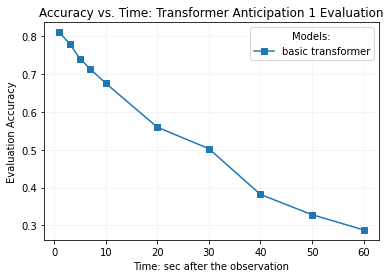

<Figure size 1440x1440 with 0 Axes>

In [21]:
plt.plot(ts, acc_basic, 's-', label="basic transformer")
plt.grid(color='0.95')
plt.legend(title='Models:')
plt.title('Accuracy vs. Time: Transformer Anticipation 1 Evaluation')
plt.xlabel("Time: sec after the observation")
plt.ylabel("Evaluation Accuracy")
plt.figure(figsize=(20,20))
plt.show()

## 2. Approach 1
Build one transformer model and take both the class of the explanation and the anticipated action as the output

p(y,e|x,t)

refer [this](https://www.pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/)

In [22]:
class TransformerModelAppr1(tf.keras.Model):
  """
  d_model = dim_action_embed + dim_time_embed

  Arch:
  Concat(action_embedding, time_embedding)  (batch_size, timesteps, d_model)
  -> N * Transformer layer                  (same shape)
  -> Average on timestep                    (batch_size, d_model)
  -> Softmax FC * 2                         (batch_size, action_size) & (batch_size, expl_size) 

  Output: batch_size probability vectors of action and explanation class
  """
  def __init__(self, num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout):
    super(TransformerModelAppr1, self).__init__()
    self.d_model = action_embed_dim + time_embed_dim
    self.num_layers = num_layers
    
    self.action_embedding = tf.keras.layers.Embedding(action_size, action_embed_dim)
    self.time_embedding = tf.keras.layers.Embedding(time_size, time_embed_dim)
    self.transformer_layers = [TransformerLayer(d_model, num_heads, dff, dropout) for _ in range(num_layers)]
    self.average_on_timestep = tf.keras.layers.GlobalAveragePooling1D()
    self.fc1 = tf.keras.layers.Dense(action_size, activation="softmax")
    self.fc2 = tf.keras.layers.Dense(expl_size, activation="softmax")

  def call(self, x):
    x, t = x[:, :-1], x[:, -1]
    # (x.shape, t.shape) = ((batch_size, timesteps), (batch_size, ))
    ut = self.time_embedding(t)  
    ut = tf.repeat(ut[:, np.newaxis, :], x.shape[1], axis=1)

    x = self.action_embedding(x)  
    x = tf.concat([x, ut], axis=2)     # (batch_size, timesteps, d_model)
    
    for i in range(self.num_layers):
      x = self.transformer_layers[i](x)
    
    x = self.average_on_timestep(x)
    action_prob = self.fc1(x)
    expl_prob = self.fc2(x)

    return {"action_prob": action_prob, "expl_prob": expl_prob}

In [23]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
time_embed_dim = 4
action_embed_dim = d_model - time_embed_dim
time_size = 61
action_size = 48
expl_size = 4
dropout = 0

Train

In [24]:
learning_rate = 1e-3
EPOCHS = 10
#optimizer = tf.optimizers.Adam(learning_rate, decay=learning_rate/EPOCHS)
optimizer = tf.optimizers.Adam(learning_rate)

In [25]:
def fitting_validation_dataset1(dataset):
  input_lst, target_lst_a, target_lst_e  = [], [], []
  for x in iter(dataset):
    inputs, action_gts, expl_class = x[0], x[1], x[2]
    expl_class = tf.cast(expl_class, tf.int32)
    batch_size = inputs.shape[0]
    for bs in range(batch_size):
      imax = 1
      while imax < 10 and action_gts[bs, imax].numpy() > 0:
        imax += 1
      i = np.random.randint(imax)
      input = np.append(inputs[bs, :].numpy(), ts[i])  # [x, t]
      target_a = np.zeros(action_size, dtype=np.int32)
      target_a[action_gts[bs, i].numpy()] = 1  # one-hot code of the action
      target_e = expl_class[bs, i, :].numpy()
      input_lst.append(input)
      target_lst_a.append(target_a)
      target_lst_e.append(target_e)

  res_set = tf.data.Dataset.from_tensor_slices((input_lst, {"action_prob": target_lst_a, "expl_prob": target_lst_e}))
  return res_set.padded_batch(BATCH_SIZE)

In [26]:
new_train_ds = [fitting_validation_dataset1(train_dataset[s]) for s in range(4)]

In [ ]:
history1 = [None for _ in range(4)]
for s in range(4):
  print("------------------------------------------------------")
  print("Take s"+str(s+1)+" dataset as the testing set and concatenate the other 3 for training.\n")
  test_set = new_train_ds[s]
  tr_is = list(set(range(4)) - {s})
  training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
  model1 = TransformerModelAppr1(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout)
  optimizer = tf.optimizers.Adam(learning_rate)
  losses = {"action_prob": "categorical_crossentropy", "expl_prob": "categorical_crossentropy"}
  lossWeights = {"action_prob": 1.0, "expl_prob": 1.0}
  model1.compile(optimizer=optimizer, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])
  history1[s] = model1.fit(x=training_set, validation_data=test_set, epochs=EPOCHS)

------------------------------------------------------
Take s1 dataset as the testing set and concatenate the other 3 for training.

Epoch 1/10
243/243 [==============================] - 270s 1s/step - loss: 2.1699 - action_prob_loss: 1.2689 - expl_prob_loss: 0.9010 - action_prob_accuracy: 0.6399 - expl_prob_accuracy: 0.6996 - val_loss: 1.6693 - val_action_prob_loss: 1.0013 - val_expl_prob_loss: 0.6680 - val_action_prob_accuracy: 0.7023 - val_expl_prob_accuracy: 0.7209
Epoch 2/10
243/243 [==============================] - 264s 1s/step - loss: 1.4762 - action_prob_loss: 0.8479 - expl_prob_loss: 0.6283 - action_prob_accuracy: 0.7278 - expl_prob_accuracy: 0.7539 - val_loss: 1.6328 - val_action_prob_loss: 0.9774 - val_expl_prob_loss: 0.6554 - val_action_prob_accuracy: 0.6979 - val_expl_prob_accuracy: 0.7490
Epoch 3/10
243/243 [==============================] - 266s 1s/step - loss: 1.4004 - action_prob_loss: 0.7953 - expl_prob_loss: 0.6051 - action_prob_accuracy: 0.7361 - expl_prob_accuracy

### save and load

In [ ]:
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
model1 = TransformerModelAppr1(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout)
optimizer = tf.optimizers.Adam(learning_rate)
losses = {"action_prob": "categorical_crossentropy", "expl_prob": "categorical_crossentropy"}
lossWeights = {"action_prob": 1.0, "expl_prob": 1.0}
model1.compile(optimizer=optimizer, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])

checkpoint_path = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr1/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model1.save_weights(checkpoint_path.format(epoch=0))
model1.fit(x=training_set, validation_data=test_set, epochs=EPOCHS, callbacks=[cp_callback])

Epoch 1/10
243/243 [==============================] - 277s 1s/step - loss: 2.0972 - action_prob_loss: 1.2646 - expl_prob_loss: 0.8326 - action_prob_accuracy: 0.6366 - expl_prob_accuracy: 0.7126 - val_loss: 1.7091 - val_action_prob_loss: 1.0353 - val_expl_prob_loss: 0.6738 - val_action_prob_accuracy: 0.7011 - val_expl_prob_accuracy: 0.7427

Epoch 00001: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr1/cp-0001.ckpt
Epoch 2/10
243/243 [==============================] - 271s 1s/step - loss: 1.4674 - action_prob_loss: 0.8424 - expl_prob_loss: 0.6250 - action_prob_accuracy: 0.7298 - expl_prob_accuracy: 0.7532 - val_loss: 1.7172 - val_action_prob_loss: 1.0135 - val_expl_prob_loss: 0.7037 - val_action_prob_accuracy: 0.6936 - val_expl_prob_accuracy: 0.7470

Epoch 00002: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr1/cp-0002.ckpt
Epoch 3/10
243/243 [==============================] - 272s 1s/step - loss:

In [ ]:
model1.evaluate(test_set, verbose=2)
# [loss, action_prob_loss, expl_prob_loss, action_prob_accuracy, expl_prob_accuracy]

40/40 - 13s - loss: 1.7088 - action_prob_loss: 0.9872 - expl_prob_loss: 0.7216 - action_prob_accuracy: 0.7067 - expl_prob_accuracy: 0.7411


[1.7087572813034058,
 0.9871628880500793,
 0.7215943336486816,
 0.7066508531570435,
 0.7410926222801208]

load

In [27]:
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
model1 = TransformerModelAppr1(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout)
optimizer = tf.optimizers.Adam(learning_rate)
losses = {"action_prob": "categorical_crossentropy", "expl_prob": "categorical_crossentropy"}
lossWeights = {"action_prob": 1.0, "expl_prob": 1.0}
model1.compile(optimizer=optimizer, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])
model1.build(next(iter(training_set))[0].shape)
checkpoint_dir = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr1"
model1.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

### Predict

In [28]:
def predict_appr1(model, feature_vec, t_lst):
  """ prediction of transformer
  model: Transformer; a transformer model.
  feature_vec: int numpy.array; a feature vector with size (timesteps, ).
  t: int numpy.array; a list of scalars in range(1, 61).
  return: a list of tuple: (action string, probability vector, action code, explanation class).
  """
  res = []
  for t in t_lst:
    x = tf.constant(np.append(feature_vec, t))[np.newaxis, :]
    prob_dict = model.predict(x)
    action_prob, expl_prob = prob_dict["action_prob"][0], prob_dict["expl_prob"][0]
    action_code = np.argmax(action_prob)
    expl_class = np.argmax(expl_prob)
    res.append((action_code, expl_class))
  
  return res

### evaluate

In [ ]:
evaluate_df_appr1 = {t:([], []) for t in ts}

batch_n = len(train_dataset[0])
counter = 0

# test set: s1 = train_dataset[0]
for obs_feature, tar_action, expl_type, expl in train_dataset[0]:
  start = time.time()
  counter += 1
  print("Start: "+str(counter)+"/"+str(batch_n))
  samp_n = obs_feature.shape[0]
  for i in range(samp_n):
    feature_vec = obs_feature[i, :].numpy()
    tar_action_codes = tar_action[i, :].numpy()
    tar_expl_class = np.argmax(expl_type[i, :, :].numpy(), axis=1)
    res = predict_appr1(model1, feature_vec, ts)
    for j in range(len(ts)):
      action_code, expl_class = res[j]
      evaluate_df_appr1[ts[j]][0].append(int(tar_action_codes[j]==action_code))
      evaluate_df_appr1[ts[j]][1].append(int(tar_expl_class[j]==expl_class))
  n = len(evaluate_df_appr1[1][0])
  print(n, "time: ", time.time()-start)
  acc_a_appr1 = [np.sum(evaluate_df_appr1[t][0])/n for t in ts]
  acc_e_appr1 = [np.sum(evaluate_df_appr1[t][1])/n for t in ts]
  print("Action accuracy: ", acc_a_appr1, "Explanation accuracy: ", acc_e_appr1)

Start: 1/40
64 time:  32.6927649974823
Action accuracy:  [0.875, 0.796875, 0.8125, 0.75, 0.703125, 0.53125, 0.5, 0.53125, 0.40625, 0.359375] Explanation accuracy:  [0.96875, 0.90625, 0.859375, 0.84375, 0.8125, 0.703125, 0.71875, 0.703125, 0.71875, 0.65625]
Start: 2/40
128 time:  32.504141092300415
Action accuracy:  [0.859375, 0.7734375, 0.7734375, 0.7265625, 0.6875, 0.546875, 0.53125, 0.5546875, 0.4609375, 0.40625] Explanation accuracy:  [0.96875, 0.9140625, 0.875, 0.84375, 0.828125, 0.6484375, 0.6484375, 0.671875, 0.671875, 0.6640625]
Start: 3/40
192 time:  31.944518089294434
Action accuracy:  [0.8385416666666666, 0.78125, 0.7760416666666666, 0.7395833333333334, 0.6875, 0.5520833333333334, 0.5260416666666666, 0.5416666666666666, 0.46875, 0.421875] Explanation accuracy:  [0.9479166666666666, 0.90625, 0.8645833333333334, 0.828125, 0.8020833333333334, 0.65625, 0.6302083333333334, 0.6458333333333334, 0.6458333333333334, 0.6510416666666666]
Start: 4/40
256 time:  32.37983298301697
Action a

save

In [ ]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/evaluate_df1_1.pickle", 'wb') as pf:
  pickle.dump(evaluate_df_appr1, pf, protocol=pickle.HIGHEST_PROTOCOL)

load

In [29]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/evaluate_df1_1.pickle", 'rb') as pf:
  evaluate_df_appr1 = pickle.load(pf)

visualize

In [30]:
n = len(evaluate_df_appr1[1][0])
acc_a_appr1 = [np.sum(evaluate_df_appr1[t][0])/n for t in ts]
acc_e_appr1 = [np.sum(evaluate_df_appr1[t][1])/n for t in ts]
print("Action accuracy: ", acc_a_appr1)
print("Explanation accuracy: ", acc_e_appr1)

Action accuracy:  [0.8044338875692795, 0.7802850356294537, 0.7525732383214568, 0.7074425969912905, 0.663895486935867, 0.5463182897862233, 0.4908946951702296, 0.45407759303246237, 0.4117181314330958, 0.38163103721298497]
Explanation accuracy:  [0.9742676167854315, 0.9212193190815519, 0.8697545526524149, 0.827790973871734, 0.7672209026128266, 0.6884402216943785, 0.6476642913697546, 0.6421219319081551, 0.6389548693586699, 0.6441013460015835]


In [31]:
acc_a_pd = pd.DataFrame(np.round(np.array([acc_basic, acc_a_appr1]), decimals=4), index=["Basic Transformer", "Approach1"], columns=["t="+str(t) for t in ts])
acc_a_pd.index.name = "Action Accuracy"
acc_a_pd

,t=1,t=3,t=5,t=7,t=10,t=20,t=30,t=40,t=50,t=60
Action Accuracy,,,,,,,,,,
Basic Transformer,0.8112,0.7807,0.7415,0.7138,0.6762,0.5598,0.5028,0.3816,0.3282,0.2878
Approach1,0.8044,0.7803,0.7526,0.7074,0.6639,0.5463,0.4909,0.4541,0.4117,0.3816


In [32]:
acc_e_pd = pd.DataFrame(np.round(np.array([acc_e_appr1]), decimals=4), index=["Approach1"], columns=["t="+str(t) for t in ts])
acc_e_pd.index.name = "Explanation Class Accuracy"
acc_e_pd

,t=1,t=3,t=5,t=7,t=10,t=20,t=30,t=40,t=50,t=60
Explanation Class Accuracy,,,,,,,,,,
Approach1,0.9743,0.9212,0.8698,0.8278,0.7672,0.6884,0.6477,0.6421,0.639,0.6441


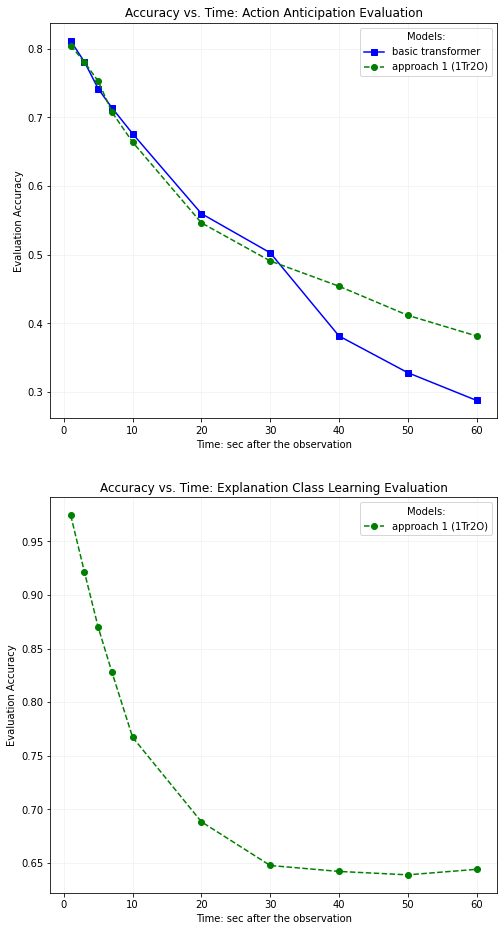

In [33]:
plt.subplot(211)
plt.plot(ts, acc_basic, 's-b', label="basic transformer")
plt.plot(ts, acc_a_appr1, 'o--g', label="approach 1 (1Tr2O)")
plt.grid(color='0.95')
plt.legend(title='Models:')
plt.title('Accuracy vs. Time: Action Anticipation Evaluation')
plt.xlabel("Time: sec after the observation")
plt.ylabel("Evaluation Accuracy")

plt.subplot(212)
plt.plot(ts, acc_e_appr1, 'o--g', label="approach 1 (1Tr2O)")
plt.grid(color='0.95')
plt.legend(title='Models:')
plt.title('Accuracy vs. Time: Explanation Class Learning Evaluation')
plt.xlabel("Time: sec after the observation")
plt.ylabel("Evaluation Accuracy")

plt.gcf().set_size_inches(8, 16)
plt.show()

## 3. Approach 2
Build two transformer models: input -> explanation class; input + explanation class -> anticipated action; we train them jointly

refer: [Learning to Explain with Complemental Examples](https://openaccess.thecvf.com/content_CVPR_2019/papers/Kanehira_Learning_to_Explain_With_Complemental_Examples_CVPR_2019_paper.pdf)

p(y,e|x,t)=p(e|x,t)p(y|e,x,t)

In [34]:
class TransformerModelAppr2(tf.keras.Model):
  """
  """
  def __init__(self, num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout):
    super(TransformerModelAppr2, self).__init__()
    self.d_model = action_embed_dim + time_embed_dim
    self.num_layers = num_layers
    
    self.action_embedding = tf.keras.layers.Embedding(action_size, action_embed_dim)
    self.time_embedding = tf.keras.layers.Embedding(time_size, time_embed_dim)
    self.transformer_layers1 = [TransformerLayer(d_model, num_heads, dff, dropout) for _ in range(num_layers)]
    self.transformer_layers2 = [TransformerLayer(d_model, num_heads, dff, dropout) for _ in range(num_layers)]
    self.average_on_timestep1 = tf.keras.layers.GlobalAveragePooling1D()
    self.average_on_timestep2 = tf.keras.layers.GlobalAveragePooling1D()
    self.projection_layer = tf.keras.layers.Dense(d_model)
    self.fc1 = tf.keras.layers.Dense(expl_size, activation="softmax")
    self.fc2 = tf.keras.layers.Dense(action_size, activation="softmax")

  def call(self, x):
    x, t = x[:, :-1], x[:, -1]
    # (x.shape, t.shape) = ((batch_size, timesteps), (batch_size, ))
    ut = self.time_embedding(t)  
    ut = tf.repeat(ut[:, np.newaxis, :], x.shape[1], axis=1)
    x = self.action_embedding(x)  
    input = tf.concat([x, ut], axis=2)     # (batch_size, timesteps, d_model)
    x = input
    
    for i in range(self.num_layers):
      x = self.transformer_layers1[i](x)
    x = self.average_on_timestep1(x)
    expl_prob = self.fc1(x)

    ue = self.projection_layer(expl_prob)
    ue = tf.repeat(ue[:, np.newaxis, :], input.shape[1], axis=1)
    x = input + ue

    for i in range(self.num_layers):
      x = self.transformer_layers2[i](x)
    x = self.average_on_timestep2(x)
    action_prob = self.fc2(x)

    return {"action_prob": action_prob, "expl_prob": expl_prob}

### Train

hyperparameters

In [35]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
time_embed_dim = 4
action_embed_dim = d_model - time_embed_dim
time_size = 61
action_size = 48
expl_size = 4
dropout = 0

In [36]:
learning_rate = 1e-3
EPOCHS = 10
#optimizer = tf.optimizers.Adam(learning_rate, decay=learning_rate/EPOCHS)
optimizer = tf.optimizers.Adam(learning_rate)

In [37]:
def fitting_validation_dataset2(dataset):
  input_lst, target_lst_a, target_lst_e  = [], [], []
  for x in iter(dataset):
    inputs, action_gts, expl_class = x[0], x[1], x[2]
    expl_class = tf.cast(expl_class, tf.int32)
    batch_size = inputs.shape[0]
    for bs in range(batch_size):
      imax = 1
      while imax < 10 and action_gts[bs, imax].numpy() > 0:
        imax += 1
      i = np.random.randint(imax)
      input = np.append(inputs[bs, :].numpy(), ts[i])  # [x, t]
      target_a = np.zeros(action_size, dtype=np.int32)
      target_a[action_gts[bs, i].numpy()] = 1  # one-hot code of the action
      target_e = expl_class[bs, i, :].numpy()
      input_lst.append(input)
      target_lst_a.append(target_a)
      target_lst_e.append(target_e)

  res_set = tf.data.Dataset.from_tensor_slices((input_lst, {"action_prob": target_lst_a, "expl_prob": target_lst_e}))
  return res_set.padded_batch(BATCH_SIZE)

In [38]:
new_train_ds = [fitting_validation_dataset2(train_dataset[s]) for s in range(4)]

In [ ]:
history2 = [None for _ in range(4)]
for s in range(4):
  print("------------------------------------------------------")
  print("Take s"+str(s+1)+" dataset as the testing set and concatenate the other 3 for training.\n")
  test_set = new_train_ds[s]
  tr_is = list(set(range(4)) - {s})
  training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
  model2 = TransformerModelAppr2(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout)
  optimizer = tf.optimizers.Adam(learning_rate)
  losses = {"action_prob": "categorical_crossentropy", "expl_prob": "categorical_crossentropy"}
  lossWeights = {"action_prob": 1.0, "expl_prob": 1.0}
  model2.compile(optimizer=optimizer, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])
  history2[s] = model2.fit(x=training_set, validation_data=test_set, epochs=EPOCHS)

### Save and load
Refer: [Tenserflow](https://www.tensorflow.org/tutorials/keras/save_and_load)

In [ ]:
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
model2 = TransformerModelAppr2(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout)
optimizer = tf.optimizers.Adam(learning_rate)
losses = {"action_prob": "categorical_crossentropy", "expl_prob": "categorical_crossentropy"}
lossWeights = {"action_prob": 1.0, "expl_prob": 1.0}
model2.compile(optimizer=optimizer, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])

checkpoint_path = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr2/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model2.save_weights(checkpoint_path.format(epoch=0))
model2.fit(x=training_set, validation_data=test_set, epochs=EPOCHS, callbacks=[cp_callback])

Epoch 1/10
243/243 [==============================] - 580s 2s/step - loss: 2.8464 - action_prob_loss: 1.9372 - expl_prob_loss: 0.9093 - action_prob_accuracy: 0.4752 - expl_prob_accuracy: 0.7043 - val_loss: 1.7398 - val_action_prob_loss: 1.0882 - val_expl_prob_loss: 0.6517 - val_action_prob_accuracy: 0.6746 - val_expl_prob_accuracy: 0.7411

Epoch 00001: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr2/cp-0001.ckpt
Epoch 2/10
243/243 [==============================] - 572s 2s/step - loss: 1.5243 - action_prob_loss: 0.8869 - expl_prob_loss: 0.6374 - action_prob_accuracy: 0.7148 - expl_prob_accuracy: 0.7525 - val_loss: 1.6949 - val_action_prob_loss: 1.0325 - val_expl_prob_loss: 0.6623 - val_action_prob_accuracy: 0.6702 - val_expl_prob_accuracy: 0.7439

Epoch 00002: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr2/cp-0002.ckpt
Epoch 3/10
243/243 [==============================] - 580s 2s/step - loss:

In [ ]:
model2.evaluate(test_set, verbose=2)
# [loss, action_prob_loss, expl_prob_loss, action_prob_accuracy, expl_prob_accuracy]

40/40 - 29s - loss: 1.7839 - action_prob_loss: 1.1193 - expl_prob_loss: 0.6647 - action_prob_accuracy: 0.6302 - expl_prob_accuracy: 0.7371


[1.783937692642212,
 1.1192784309387207,
 0.6646595001220703,
 0.6302454471588135,
 0.737133800983429]

In [39]:
# Loads the weights
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
model2 = TransformerModelAppr2(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout)
optimizer = tf.optimizers.Adam(learning_rate)
losses = {"action_prob": "categorical_crossentropy", "expl_prob": "categorical_crossentropy"}
lossWeights = {"action_prob": 1.0, "expl_prob": 1.0}
model2.compile(optimizer=optimizer, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])
model2.build(next(iter(training_set))[0].shape)
checkpoint_dir = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr2"
model2.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

### Predict

In [40]:
def predict_appr2(model, feature_vec, t_lst):
  """ prediction of transformer
  model: Transformer; a transformer model.
  feature_vec: int numpy.array; a feature vector with size (timesteps, ).
  t: int numpy.array; a list of scalars in range(1, 61).
  return: a list of tuple: (action string, probability vector, action code, explanation class).
  """
  res = []
  for t in t_lst:
    x = tf.constant(np.append(feature_vec, t))[np.newaxis, :]
    prob_dict = model.predict(x)
    action_prob, expl_prob = prob_dict["action_prob"][0], prob_dict["expl_prob"][0]
    action_code = np.argmax(action_prob)
    expl_class = np.argmax(expl_prob)
    res.append((action_code, expl_class))
  
  return res

### Evaluate

In [ ]:
evaluate_df_appr2 = {t:([], []) for t in ts}

batch_n = len(train_dataset[0])
counter = 0

# test set: s1 = train_dataset[0]
for obs_feature, tar_action, expl_type, expl in train_dataset[0]:
  start = time.time()
  counter += 1
  print("Start: "+str(counter)+"/"+str(batch_n))
  samp_n = obs_feature.shape[0]
  for i in range(samp_n):
    feature_vec = obs_feature[i, :].numpy()
    tar_action_codes = tar_action[i, :].numpy()
    tar_expl_class = np.argmax(expl_type[i, :, :].numpy(), axis=1)
    res = predict_appr2(model2, feature_vec, ts)
    for j in range(len(ts)):
      action_code, expl_class = res[j]
      evaluate_df_appr2[ts[j]][0].append(int(tar_action_codes[j]==action_code))
      evaluate_df_appr2[ts[j]][1].append(int(tar_expl_class[j]==expl_class))
  n = len(evaluate_df_appr2[1][0])
  print(n, "time: ", time.time()-start)
  acc_a_appr2 = [np.sum(evaluate_df_appr2[t][0])/n for t in ts]
  acc_e_appr2 = [np.sum(evaluate_df_appr2[t][1])/n for t in ts]
  print("Action accuracy: ", acc_a_appr2, "Explanation accuracy: ", acc_e_appr2)

Start: 1/40
64 time:  45.33224606513977
Action accuracy:  [0.75, 0.765625, 0.75, 0.765625, 0.671875, 0.53125, 0.46875, 0.4375, 0.4375, 0.328125] Explanation accuracy:  [1.0, 0.953125, 0.890625, 0.84375, 0.828125, 0.71875, 0.640625, 0.625, 0.625, 0.46875]
Start: 2/40
128 time:  41.67836618423462
Action accuracy:  [0.6875, 0.703125, 0.6953125, 0.6875, 0.6171875, 0.53125, 0.4765625, 0.4375, 0.4296875, 0.3359375] Explanation accuracy:  [0.9921875, 0.9296875, 0.875, 0.8125, 0.7578125, 0.65625, 0.5859375, 0.6171875, 0.6171875, 0.5078125]
Start: 3/40
192 time:  42.067462682724
Action accuracy:  [0.6979166666666666, 0.71875, 0.6614583333333334, 0.6770833333333334, 0.609375, 0.5416666666666666, 0.4739583333333333, 0.4322916666666667, 0.4114583333333333, 0.3333333333333333] Explanation accuracy:  [0.9895833333333334, 0.9375, 0.859375, 0.8125, 0.7760416666666666, 0.6770833333333334, 0.625, 0.640625, 0.640625, 0.5572916666666666]
Start: 4/40
256 time:  41.35185503959656
Action accuracy:  [0.691406

Save

In [ ]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/evaluate_df1_2.pickle", 'wb') as pf:
  pickle.dump(evaluate_df_appr2, pf, protocol=pickle.HIGHEST_PROTOCOL)

Load

In [41]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/evaluate_df1_2.pickle", 'rb') as pf:
  evaluate_df_appr2 = pickle.load(pf)

Visualize

In [42]:
n = len(evaluate_df_appr2[1][0])
acc_a_appr2 = [np.sum(evaluate_df_appr2[t][0])/n for t in ts]
acc_e_appr2 = [np.sum(evaluate_df_appr2[t][1])/n for t in ts]
print("Action accuracy: ", acc_a_appr2)
print("Explanation accuracy: ", acc_e_appr2)

Action accuracy:  [0.7026920031670626, 0.6995249406175772, 0.6504354711005542, 0.6476642913697546, 0.5930324623911323, 0.5217735550277118, 0.47228820269200317, 0.4271575613618369, 0.38796516231195566, 0.3440221694378464]
Explanation accuracy:  [0.9742676167854315, 0.9212193190815519, 0.8709422011084719, 0.8305621536025336, 0.7838479809976246, 0.6737925574030087, 0.6405384006334125, 0.6088677751385589, 0.5977830562153602, 0.5839271575613618]


In [43]:
acc_a_pd = pd.DataFrame(np.round(np.array([acc_basic, acc_a_appr1, acc_a_appr2]), decimals=4), index=["Basic Transformer", "Approach1", "Approach2"], columns=["t="+str(t) for t in ts])
acc_a_pd.index.name = "Action Accuracy"
acc_a_pd

,t=1,t=3,t=5,t=7,t=10,t=20,t=30,t=40,t=50,t=60
Action Accuracy,,,,,,,,,,
Basic Transformer,0.8112,0.7807,0.7415,0.7138,0.6762,0.5598,0.5028,0.3816,0.3282,0.2878
Approach1,0.8044,0.7803,0.7526,0.7074,0.6639,0.5463,0.4909,0.4541,0.4117,0.3816
Approach2,0.7027,0.6995,0.6504,0.6477,0.5930,0.5218,0.4723,0.4272,0.3880,0.3440


In [44]:
acc_e_pd = pd.DataFrame(np.round(np.array([acc_e_appr1, acc_e_appr2]), decimals=4), index=["Approach1", "Approach2"], columns=["t="+str(t) for t in ts])
acc_e_pd.index.name = "Explanation Class Accuracy"
acc_e_pd

,t=1,t=3,t=5,t=7,t=10,t=20,t=30,t=40,t=50,t=60
Explanation Class Accuracy,,,,,,,,,,
Approach1,0.9743,0.9212,0.8698,0.8278,0.7672,0.6884,0.6477,0.6421,0.6390,0.6441
Approach2,0.9743,0.9212,0.8709,0.8306,0.7838,0.6738,0.6405,0.6089,0.5978,0.5839


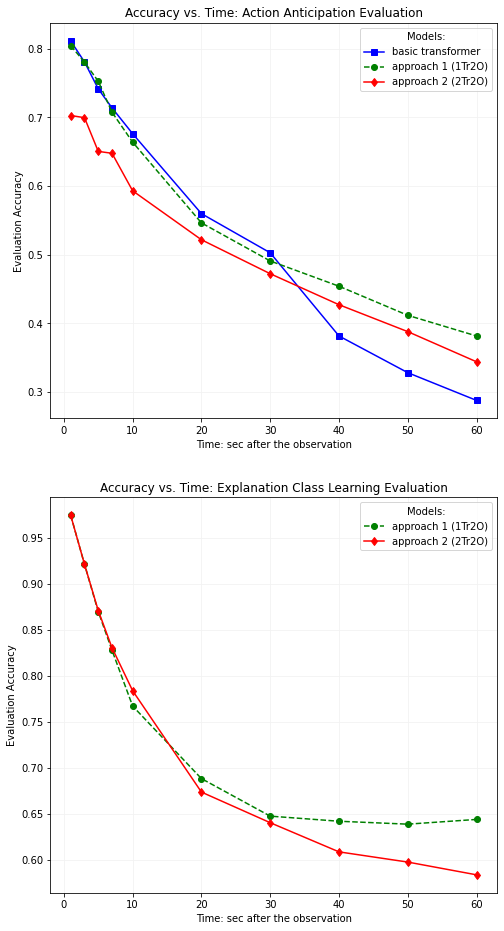

In [45]:
plt.subplot(211)
plt.plot(ts, acc_basic, 's-b', label="basic transformer")
plt.plot(ts, acc_a_appr1, 'o--g', label="approach 1 (1Tr2O)")
plt.plot(ts, acc_a_appr2, 'd-r', label="approach 2 (2Tr2O)")
plt.grid(color='0.95')
plt.legend(title='Models:')
plt.title('Accuracy vs. Time: Action Anticipation Evaluation')
plt.xlabel("Time: sec after the observation")
plt.ylabel("Evaluation Accuracy")

plt.subplot(212)
plt.plot(ts, acc_e_appr1, 'o--g', label="approach 1 (1Tr2O)")
plt.plot(ts, acc_e_appr2, 'd-r', label="approach 2 (2Tr2O)")
plt.grid(color='0.95')
plt.legend(title='Models:')
plt.title('Accuracy vs. Time: Explanation Class Learning Evaluation')
plt.xlabel("Time: sec after the observation")
plt.ylabel("Evaluation Accuracy")

plt.gcf().set_size_inches(8, 16)
plt.show()

## 4. Approach 3
Build two transformer models: input -> anticipated action; input + anticipated action -> explanation class

p(y,e|x,t)=p(y|x,t)p(e|y,x,t)

In [46]:
class TransformerModelAppr3(tf.keras.Model):
  """
  """
  def __init__(self, num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout):
    super(TransformerModelAppr3, self).__init__()
    self.d_model = action_embed_dim + time_embed_dim
    self.num_layers = num_layers
    
    self.action_embedding = tf.keras.layers.Embedding(action_size, action_embed_dim)
    self.time_embedding = tf.keras.layers.Embedding(time_size, time_embed_dim)
    self.transformer_layers1 = [TransformerLayer(d_model, num_heads, dff, dropout) for _ in range(num_layers)]
    self.transformer_layers2 = [TransformerLayer(d_model, num_heads, dff, dropout) for _ in range(num_layers)]
    self.average_on_timestep1 = tf.keras.layers.GlobalAveragePooling1D()
    self.average_on_timestep2 = tf.keras.layers.GlobalAveragePooling1D()
    self.projection_layer = tf.keras.layers.Dense(d_model)
    self.fc1 = tf.keras.layers.Dense(action_size, activation="softmax")
    self.fc2 = tf.keras.layers.Dense(expl_size, activation="softmax")

  def call(self, x):
    x, t = x[:, :-1], x[:, -1]
    # (x.shape, t.shape) = ((batch_size, timesteps), (batch_size, ))
    ut = self.time_embedding(t)  
    ut = tf.repeat(ut[:, np.newaxis, :], x.shape[1], axis=1)
    x = self.action_embedding(x)  
    input = tf.concat([x, ut], axis=2)     # (batch_size, timesteps, d_model)
    x = input
    
    for i in range(self.num_layers):
      x = self.transformer_layers1[i](x)
    x = self.average_on_timestep1(x)
    action_prob = self.fc1(x)

    ua = self.projection_layer(action_prob)
    ua = tf.repeat(ua[:, np.newaxis, :], input.shape[1], axis=1)
    x = input + ua

    for i in range(self.num_layers):
      x = self.transformer_layers2[i](x)
    x = self.average_on_timestep2(x)
    expl_prob = self.fc2(x)

    return {"action_prob": action_prob, "expl_prob": expl_prob}

### Train

hyperparameters

In [47]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
time_embed_dim = 4
action_embed_dim = d_model - time_embed_dim
time_size = 61
action_size = 48
expl_size = 4
dropout = 0

In [48]:
learning_rate = 1e-3
EPOCHS = 10
#optimizer = tf.optimizers.Adam(learning_rate, decay=learning_rate/EPOCHS)
optimizer = tf.optimizers.Adam(learning_rate)

In [49]:
def fitting_validation_dataset3(dataset):
  input_lst, target_lst_a, target_lst_e  = [], [], []
  for x in iter(dataset):
    inputs, action_gts, expl_class = x[0], x[1], x[2]
    expl_class = tf.cast(expl_class, tf.int32)
    batch_size = inputs.shape[0]
    for bs in range(batch_size):
      imax = 1
      while imax < 10 and action_gts[bs, imax].numpy() > 0:
        imax += 1
      i = np.random.randint(imax)
      input = np.append(inputs[bs, :].numpy(), ts[i])  # [x, t]
      target_a = np.zeros(action_size, dtype=np.int32)
      target_a[action_gts[bs, i].numpy()] = 1  # one-hot code of the action
      target_e = expl_class[bs, i, :].numpy()
      input_lst.append(input)
      target_lst_a.append(target_a)
      target_lst_e.append(target_e)

  res_set = tf.data.Dataset.from_tensor_slices((input_lst, {"action_prob": target_lst_a, "expl_prob": target_lst_e}))
  return res_set.padded_batch(BATCH_SIZE)

In [50]:
new_train_ds = [fitting_validation_dataset3(train_dataset[s]) for s in range(4)]

In [ ]:
history3 = [None for _ in range(4)]
for s in range(4):
  print("------------------------------------------------------")
  print("Take s"+str(s+1)+" dataset as the testing set and concatenate the other 3 for training.\n")
  test_set = new_train_ds[s]
  tr_is = list(set(range(4)) - {s})
  training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
  model3 = TransformerModelAppr3(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout)
  optimizer = tf.optimizers.Adam(learning_rate)
  losses = {"action_prob": "categorical_crossentropy", "expl_prob": "categorical_crossentropy"}
  lossWeights = {"action_prob": 1.0, "expl_prob": 1.0}
  model3.compile(optimizer=optimizer, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])
  history3[s] = model3.fit(x=training_set, validation_data=test_set, epochs=EPOCHS)

### Save and load
Refer: [Tenserflow](https://www.tensorflow.org/tutorials/keras/save_and_load)

In [51]:
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
model3 = TransformerModelAppr3(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout)
optimizer = tf.optimizers.Adam(learning_rate)
losses = {"action_prob": "categorical_crossentropy", "expl_prob": "categorical_crossentropy"}
lossWeights = {"action_prob": 1.0, "expl_prob": 1.0}
model3.compile(optimizer=optimizer, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])

checkpoint_path = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr3/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model3.save_weights(checkpoint_path.format(epoch=0))
model3.fit(x=training_set, validation_data=test_set, epochs=EPOCHS, callbacks=[cp_callback])

Epoch 1/10
243/243 [==============================] - 599s 2s/step - loss: 2.2042 - action_prob_loss: 1.3025 - expl_prob_loss: 0.9017 - action_prob_accuracy: 0.6196 - expl_prob_accuracy: 0.6958 - val_loss: 1.7353 - val_action_prob_loss: 1.0763 - val_expl_prob_loss: 0.6591 - val_action_prob_accuracy: 0.6552 - val_expl_prob_accuracy: 0.7470

Epoch 00001: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr3/cp-0001.ckpt
Epoch 2/10
243/243 [==============================] - 591s 2s/step - loss: 1.5600 - action_prob_loss: 0.8749 - expl_prob_loss: 0.6851 - action_prob_accuracy: 0.7129 - expl_prob_accuracy: 0.7263 - val_loss: 1.6405 - val_action_prob_loss: 0.9754 - val_expl_prob_loss: 0.6651 - val_action_prob_accuracy: 0.6900 - val_expl_prob_accuracy: 0.7415

Epoch 00002: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr3/cp-0002.ckpt
Epoch 3/10
243/243 [==============================] - 584s 2s/step - loss:

In [52]:
model3.evaluate(test_set, verbose=2)
# [loss, action_prob_loss, expl_prob_loss, action_prob_accuracy, expl_prob_accuracy]

40/40 - 28s - loss: 1.5875 - action_prob_loss: 0.9480 - expl_prob_loss: 0.6395 - action_prob_accuracy: 0.7110 - expl_prob_accuracy: 0.7577


[1.5874783992767334,
 0.9479565620422363,
 0.6395217776298523,
 0.7110055685043335,
 0.7577196955680847]

In [ ]:
# Loads the weights
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
model3 = TransformerModelAppr3(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout)
optimizer = tf.optimizers.Adam(learning_rate)
losses = {"action_prob": "categorical_crossentropy", "expl_prob": "categorical_crossentropy"}
lossWeights = {"action_prob": 1.0, "expl_prob": 1.0}
model3.compile(optimizer=optimizer, loss=losses, loss_weights=lossWeights, metrics=["accuracy"])
model3.build(next(iter(training_set))[0].shape)
checkpoint_dir = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr3"
model3.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

### Predict

In [53]:
def predict_appr3(model, feature_vec, t_lst):
  """ prediction of transformer
  model: Transformer; a transformer model.
  feature_vec: int numpy.array; a feature vector with size (timesteps, ).
  t: int numpy.array; a list of scalars in range(1, 61).
  return: a list of tuple: (action string, probability vector, action code, explanation class).
  """
  res = []
  for t in t_lst:
    x = tf.constant(np.append(feature_vec, t))[np.newaxis, :]
    prob_dict = model.predict(x)
    action_prob, expl_prob = prob_dict["action_prob"][0], prob_dict["expl_prob"][0]
    action_code = np.argmax(action_prob)
    expl_class = np.argmax(expl_prob)
    res.append((action_code, expl_class))
  
  return res

### Evaluate

In [54]:
evaluate_df_appr3 = {t:([], []) for t in ts}

batch_n = len(train_dataset[0])
counter = 0

# test set: s1 = train_dataset[0]
for obs_feature, tar_action, expl_type, expl in train_dataset[0]:
  start = time.time()
  counter += 1
  print("Start: "+str(counter)+"/"+str(batch_n))
  samp_n = obs_feature.shape[0]
  for i in range(samp_n):
    feature_vec = obs_feature[i, :].numpy()
    tar_action_codes = tar_action[i, :].numpy()
    tar_expl_class = np.argmax(expl_type[i, :, :].numpy(), axis=1)
    res = predict_appr3(model3, feature_vec, ts)
    for j in range(len(ts)):
      action_code, expl_class = res[j]
      evaluate_df_appr3[ts[j]][0].append(int(tar_action_codes[j]==action_code))
      evaluate_df_appr3[ts[j]][1].append(int(tar_expl_class[j]==expl_class))
  n = len(evaluate_df_appr3[1][0])
  print(n, "time: ", time.time()-start)
  acc_a_appr3 = [np.sum(evaluate_df_appr3[t][0])/n for t in ts]
  acc_e_appr3 = [np.sum(evaluate_df_appr3[t][1])/n for t in ts]
  print("Action accuracy: ", acc_a_appr3, "Explanation accuracy: ", acc_e_appr3)

Start: 1/40
64 time:  40.47548031806946
Action accuracy:  [0.84375, 0.796875, 0.734375, 0.703125, 0.671875, 0.609375, 0.578125, 0.546875, 0.46875, 0.40625] Explanation accuracy:  [0.984375, 0.9375, 0.90625, 0.828125, 0.78125, 0.75, 0.625, 0.625, 0.578125, 0.5]
Start: 2/40
128 time:  39.88177561759949
Action accuracy:  [0.859375, 0.8125, 0.7578125, 0.7265625, 0.6875, 0.578125, 0.5625, 0.5390625, 0.4765625, 0.421875] Explanation accuracy:  [0.984375, 0.921875, 0.875, 0.8359375, 0.796875, 0.6796875, 0.6640625, 0.625, 0.5625, 0.4921875]
Start: 3/40
192 time:  40.106032848358154
Action accuracy:  [0.84375, 0.8125, 0.7604166666666666, 0.75, 0.671875, 0.5833333333333334, 0.5208333333333334, 0.5104166666666666, 0.4427083333333333, 0.40625] Explanation accuracy:  [0.9791666666666666, 0.9270833333333334, 0.8854166666666666, 0.859375, 0.8020833333333334, 0.6822916666666666, 0.65625, 0.6510416666666666, 0.5885416666666666, 0.5364583333333334]
Start: 4/40
256 time:  40.11046075820923
Action accurac

Save

In [55]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/evaluate_df1_3.pickle", 'wb') as pf:
  pickle.dump(evaluate_df_appr3, pf, protocol=pickle.HIGHEST_PROTOCOL)

Load

In [ ]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/evaluate_df1_3.pickle", 'rb') as pf:
  evaluate_df_appr3 = pickle.load(pf)

Visualize

In [56]:
n = len(evaluate_df_appr3[1][0])
acc_a_appr3 = [np.sum(evaluate_df_appr3[t][0])/n for t in ts]
acc_e_appr3 = [np.sum(evaluate_df_appr3[t][1])/n for t in ts]
print("Action accuracy: ", acc_a_appr3)
print("Explanation accuracy: ", acc_e_appr3)

Action accuracy:  [0.8392715756136183, 0.8024544734758512, 0.7509897070467142, 0.7157561361836896, 0.6567695961995249, 0.5629453681710214, 0.497624703087886, 0.46080760095011875, 0.4220110847189232, 0.384006334125099]
Explanation accuracy:  [0.9742676167854315, 0.9212193190815519, 0.8709422011084719, 0.8281868566904196, 0.7818685669041964, 0.6373713380839272, 0.601741884402217, 0.5930324623911323, 0.5661124307205068, 0.5130641330166271]


In [57]:
acc_a_pd = pd.DataFrame(np.round(np.array([acc_basic, acc_a_appr1, acc_a_appr2, acc_a_appr3]), decimals=4), index=["Basic Transformer", "Approach1", "Approach2", "Approach3"], columns=["t="+str(t) for t in ts])
acc_a_pd.index.name = "Action Accuracy"
acc_a_pd

,t=1,t=3,t=5,t=7,t=10,t=20,t=30,t=40,t=50,t=60
Action Accuracy,,,,,,,,,,
Basic Transformer,0.8112,0.7807,0.7415,0.7138,0.6762,0.5598,0.5028,0.3816,0.3282,0.2878
Approach1,0.8044,0.7803,0.7526,0.7074,0.6639,0.5463,0.4909,0.4541,0.4117,0.3816
Approach2,0.7027,0.6995,0.6504,0.6477,0.5930,0.5218,0.4723,0.4272,0.3880,0.3440
Approach3,0.8393,0.8025,0.7510,0.7158,0.6568,0.5629,0.4976,0.4608,0.4220,0.3840


In [58]:
acc_e_pd = pd.DataFrame(np.round(np.array([acc_e_appr1, acc_e_appr2, acc_e_appr3]), decimals=4), index=["Approach1", "Approach2", "Approach3"], columns=["t="+str(t) for t in ts])
acc_e_pd.index.name = "Explanation Class Accuracy"
acc_e_pd

,t=1,t=3,t=5,t=7,t=10,t=20,t=30,t=40,t=50,t=60
Explanation Class Accuracy,,,,,,,,,,
Approach1,0.9743,0.9212,0.8698,0.8278,0.7672,0.6884,0.6477,0.6421,0.6390,0.6441
Approach2,0.9743,0.9212,0.8709,0.8306,0.7838,0.6738,0.6405,0.6089,0.5978,0.5839
Approach3,0.9743,0.9212,0.8709,0.8282,0.7819,0.6374,0.6017,0.5930,0.5661,0.5131


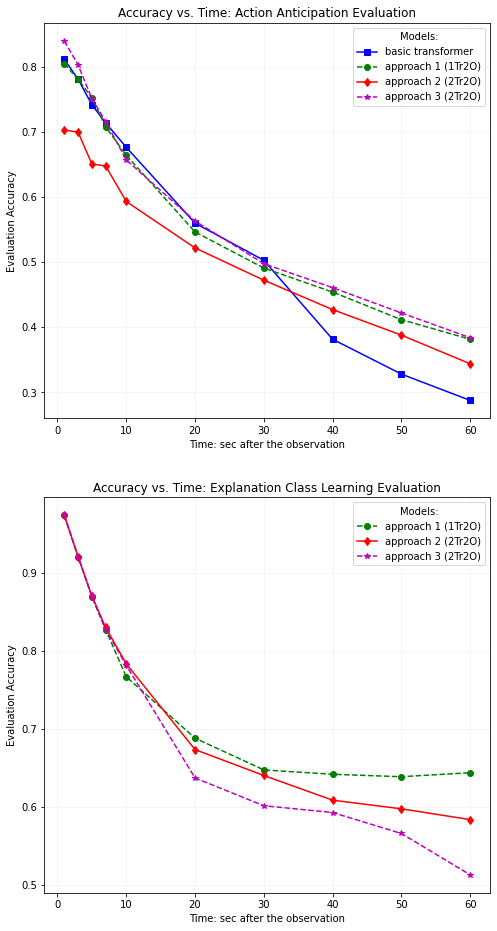

In [59]:
plt.subplot(211)
plt.plot(ts, acc_basic, 's-b', label="basic transformer")
plt.plot(ts, acc_a_appr1, 'o--g', label="approach 1 (1Tr2O)")
plt.plot(ts, acc_a_appr2, 'd-r', label="approach 2 (2Tr2O)")
plt.plot(ts, acc_a_appr3, '*--m', label="approach 3 (2Tr2O)")
plt.grid(color='0.95')
plt.legend(title='Models:')
plt.title('Accuracy vs. Time: Action Anticipation Evaluation')
plt.xlabel("Time: sec after the observation")
plt.ylabel("Evaluation Accuracy")

plt.subplot(212)
plt.plot(ts, acc_e_appr1, 'o--g', label="approach 1 (1Tr2O)")
plt.plot(ts, acc_e_appr2, 'd-r', label="approach 2 (2Tr2O)")
plt.plot(ts, acc_e_appr3, '*--m', label="approach 3 (2Tr2O)")
plt.grid(color='0.95')
plt.legend(title='Models:')
plt.title('Accuracy vs. Time: Explanation Class Learning Evaluation')
plt.xlabel("Time: sec after the observation")
plt.ylabel("Evaluation Accuracy")

plt.gcf().set_size_inches(8, 16)
plt.show()

## 5. Approach 4
Train separately

### Part 1

In [60]:
class TransformerExplAppr4(tf.keras.Model):
  """
  d_model = dim_action_embed + dim_time_embed

  Arch:
  Concat(action_embedding, time_embedding)  (batch_size, timesteps, d_model)
  -> N * Transformer layer                  (same shape)
  -> Average on timestep                    (batch_size, d_model)
  -> Softmax FC                             (batch_size, expl_size)

  Output: batch_size probability vectors
  """
  def __init__(self, num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, expl_size, dropout):
    super(TransformerExplAppr4, self).__init__()
    self.d_model = action_embed_dim + time_embed_dim
    self.num_layers = num_layers
    
    self.action_embedding = tf.keras.layers.Embedding(action_size, action_embed_dim)
    self.time_embedding = tf.keras.layers.Embedding(time_size, time_embed_dim)
    self.transformer_layers = [TransformerLayer(d_model, num_heads, dff, dropout)  for _ in range(num_layers)]
    self.average_on_timestep = tf.keras.layers.GlobalAveragePooling1D()
    self.final_layer = tf.keras.layers.Dense(expl_size, activation="softmax")

  def call(self, x):
    x, t = x[:, :-1], x[:, -1]
    # (x.shape, t.shape) = ((batch_size, timesteps), (batch_size, ))
    ut = self.time_embedding(t)  
    ut = tf.repeat(ut[:, np.newaxis, :], x.shape[1], axis=1)

    x = self.action_embedding(x)  
    x = tf.concat([x, ut], axis=2)     # (batch_size, timesteps, d_model)
    
    for i in range(self.num_layers):
      x = self.transformer_layers[i](x)
    
    x = self.average_on_timestep(x)
    expl_prob = self.final_layer(x)
    return expl_prob

In [61]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
time_embed_dim = 4
action_embed_dim = d_model - time_embed_dim
time_size = 61
action_size = 48
expl_size = 4
dropout = 0

In [62]:
learning_rate = 1e-3
EPOCHS = 10
#optimizer = tf.optimizers.Adam(learning_rate, decay=learning_rate/EPOCHS)
optimizer = tf.optimizers.Adam(learning_rate)

In [63]:
def fitting_validation_dataset4_1(dataset):
  input_lst, target_lst = [], []
  for x in iter(dataset):
    inputs, action_gts, expl_class = x[0], x[1], x[2]
    expl_class = tf.cast(expl_class, tf.int32)
    batch_size = inputs.shape[0]
    for bs in range(batch_size):
      imax = 1
      while imax < 10 and action_gts[bs, imax].numpy() > 0:
        imax += 1
      i = np.random.randint(imax)
      input = np.append(inputs[bs, :].numpy(), ts[i])  # [x, t]
      target = expl_class[bs, i, :].numpy()
      input_lst.append(input)
      target_lst.append(target)

  res_set = tf.data.Dataset.from_tensor_slices((input_lst, target_lst))
  return res_set.padded_batch(BATCH_SIZE)

In [64]:
new_train_ds = [fitting_validation_dataset4_1(train_dataset[s]) for s in range(4)]

In [ ]:
history = [None for _ in range(4)]
for s in range(4):
  print("------------------------------------------------------")
  print("Take s"+str(s+1)+" dataset as the testing set and concatenate the other 3 for training.\n")
  test_set = new_train_ds[s]
  tr_is = list(set(range(4)) - {s})
  training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
  model4_1 = TransformerExplAppr4(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, expl_size, dropout)
  optimizer = tf.optimizers.Adam(learning_rate)
  model4_1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
  history[s] = model4_1.fit(x=training_set, validation_data=test_set, epochs=EPOCHS)

In [66]:
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
model4_1 = TransformerExplAppr4(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, expl_size, dropout)
optimizer = tf.optimizers.Adam(learning_rate)
model4_1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint_path = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr4/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model4_1.save_weights(checkpoint_path.format(epoch=0))
model4_1.fit(x=training_set, validation_data=test_set, epochs=EPOCHS, callbacks=[cp_callback])

Epoch 1/10
243/243 [==============================] - 292s 1s/step - loss: 0.8867 - accuracy: 0.7040 - val_loss: 0.6840 - val_accuracy: 0.7316

Epoch 00001: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr4/cp-0001.ckpt
Epoch 2/10
243/243 [==============================] - 286s 1s/step - loss: 0.6401 - accuracy: 0.7488 - val_loss: 0.6774 - val_accuracy: 0.7387

Epoch 00002: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr4/cp-0002.ckpt
Epoch 3/10
243/243 [==============================] - 288s 1s/step - loss: 0.6206 - accuracy: 0.7597 - val_loss: 0.6731 - val_accuracy: 0.7375

Epoch 00003: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr4/cp-0003.ckpt
Epoch 4/10
243/243 [==============================] - 287s 1s/step - loss: 0.6119 - accuracy: 0.7610 - val_loss: 0.6969 - val_accuracy: 0.7257

Epoch 00004: saving model to /content/drive/MyDrive/FurtherSt

In [67]:
model4_1.evaluate(test_set, verbose=2)

40/40 - 15s - loss: 0.6903 - accuracy: 0.7336


[0.6903063654899597, 0.7335708737373352]

In [ ]:
# Loads the weights
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
model4_1 = TransformerExplAppr4(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, expl_size, dropout)
optimizer = tf.optimizers.Adam(learning_rate)
model4_1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model4_1.build(next(iter(training_set))[0].shape)
checkpoint_dir = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr4"
model4_1.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

### Part 2

In [68]:
class TransformerActionAppr4(tf.keras.Model):
  """
  """
  def __init__(self, num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout):
    super(TransformerActionAppr4, self).__init__()
    self.d_model = action_embed_dim + time_embed_dim + expl_size
    self.num_layers = num_layers
    
    self.action_embedding = tf.keras.layers.Embedding(action_size, action_embed_dim)
    self.time_embedding = tf.keras.layers.Embedding(time_size, time_embed_dim)
    self.transformer_layers = [TransformerLayer(d_model, num_heads, dff, dropout)  for _ in range(num_layers)]
    self.average_on_timestep = tf.keras.layers.GlobalAveragePooling1D()
    self.final_layer = tf.keras.layers.Dense(action_size, activation="softmax")

  def call(self, x):
    x, ue = x["x"], x["e"]

    x, t = x[:, :-1], x[:, -1]
    # (x.shape, t.shape) = ((batch_size, timesteps), (batch_size, ))
    ut = self.time_embedding(t)  
    ut = tf.repeat(ut[:, np.newaxis, :], x.shape[1], axis=1)

    ue = tf.repeat(ue[:, np.newaxis, :], x.shape[1], axis=1)

    x = self.action_embedding(x)  
    x = tf.concat([x, ut, ue], axis=2)     # (batch_size, timesteps, d_model)
    
    for i in range(self.num_layers):
      x = self.transformer_layers[i](x)
    
    x = self.average_on_timestep(x)
    action_prob = self.final_layer(x)
    return action_prob

In [69]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
time_embed_dim = 4

time_size = 61
action_size = 48
expl_size = 4
dropout = 0

action_embed_dim = d_model - time_embed_dim - expl_size

In [70]:
learning_rate = 1e-3
EPOCHS = 10
#optimizer = tf.optimizers.Adam(learning_rate, decay=learning_rate/EPOCHS)
optimizer = tf.optimizers.Adam(learning_rate)

In [74]:
def fitting_validation_dataset4_2(dataset):
  input_lst_x, input_lst_e, target_lst  = [], [], []
  for x in iter(dataset):
    inputs, action_gts, expl_class = x[0], x[1], x[2]
    batch_size = inputs.shape[0]
    for bs in range(batch_size):
      imax = 1
      while imax < 10 and action_gts[bs, imax].numpy() > 0:
        imax += 1
      i = np.random.randint(imax)
      input_x = np.append(inputs[bs, :].numpy(), ts[i])  # [x, t]
      input_e = expl_class[bs, i, :].numpy()

      target = np.zeros(action_size, dtype=np.int32)
      target[action_gts[bs, i].numpy()] = 1  # one-hot code of the action
      
      input_lst_x.append(input_x)
      input_lst_e.append(input_e)
      target_lst.append(target)

  res_set = tf.data.Dataset.from_tensor_slices(({"x": input_lst_x, "e": input_lst_e}, target_lst))
  return res_set.padded_batch(BATCH_SIZE)

In [75]:
new_train_ds = [fitting_validation_dataset4_2(train_dataset[s]) for s in range(4)]

In [ ]:
history = [None for _ in range(4)]
for s in range(4):
  print("------------------------------------------------------")
  print("Take s"+str(s+1)+" dataset as the testing set and concatenate the other 3 for training.\n")
  test_set = new_train_ds[s]
  tr_is = list(set(range(4)) - {s})
  training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
  model4_2 = TransformerActionAppr4(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout)
  optimizer = tf.optimizers.Adam(learning_rate)
  model4_2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
  history[s] = model4_2.fit(x=training_set, validation_data=test_set, epochs=EPOCHS)

In [76]:
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
model4_2 = TransformerActionAppr4(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout)
optimizer = tf.optimizers.Adam(learning_rate)
model4_2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint_path = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr4_2/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model4_2.save_weights(checkpoint_path.format(epoch=0))
model4_2.fit(x=training_set, validation_data=test_set, epochs=EPOCHS, callbacks=[cp_callback])

Epoch 1/10
243/243 [==============================] - 292s 1s/step - loss: 1.3566 - accuracy: 0.6227 - val_loss: 0.8531 - val_accuracy: 0.7296

Epoch 00001: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr4_2/cp-0001.ckpt
Epoch 2/10
243/243 [==============================] - 282s 1s/step - loss: 0.5689 - accuracy: 0.8069 - val_loss: 0.6693 - val_accuracy: 0.7724

Epoch 00002: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr4_2/cp-0002.ckpt
Epoch 3/10
243/243 [==============================] - 281s 1s/step - loss: 0.4880 - accuracy: 0.8318 - val_loss: 0.6964 - val_accuracy: 0.7926

Epoch 00003: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr4_2/cp-0003.ckpt
Epoch 4/10
243/243 [==============================] - 283s 1s/step - loss: 0.4590 - accuracy: 0.8427 - val_loss: 0.6598 - val_accuracy: 0.7985

Epoch 00004: saving model to /content/drive/MyDrive/Fur

In [77]:
model4_2.evaluate(test_set, verbose=2)

40/40 - 14s - loss: 0.7162 - accuracy: 0.7827


[0.7162323594093323, 0.7826603055000305]

In [ ]:
# Loads the weights
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
model4_2 = TransformerActionAppr4(num_layers, action_embed_dim, time_embed_dim, num_heads, dff, time_size, action_size, expl_size, dropout)
optimizer = tf.optimizers.Adam(learning_rate)
model4_2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model4_2.build(next(iter(training_set))[0].shape)
checkpoint_dir = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/transformer1_appr4_2"
model4_2.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

### evaluate

In [78]:
def fitting_validation_dataset4(dataset):
  input_lst, target_lst_a, target_lst_e  = [], [], []
  for x in iter(dataset):
    inputs, action_gts, expl_class = x[0], x[1], x[2]
    batch_size = inputs.shape[0]
    for bs in range(batch_size):
      imax = 1
      while imax < 10 and action_gts[bs, imax].numpy() > 0:
        imax += 1
      i = np.random.randint(imax)
      input = np.append(inputs[bs, :].numpy(), ts[i])  # [x, t]
      target_a = np.zeros(action_size, dtype=np.int32)
      target_a[action_gts[bs, i].numpy()] = 1  # one-hot code of the action
      target_e = expl_class[bs, i, :].numpy()
      input_lst.append(input)
      target_lst_a.append(target_a)
      target_lst_e.append(target_e)

  res_set = tf.data.Dataset.from_tensor_slices((input_lst, {"action_prob": target_lst_a, "expl_prob": target_lst_e}))
  return res_set.padded_batch(BATCH_SIZE)

In [79]:
new_train_ds = [fitting_validation_dataset4(train_dataset[s]) for s in range(4)]
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])

In [80]:
def predict_appr4(mod1, mod2, feature_vec, t_lst):
  """ prediction of transformer
  model: Transformer; a transformer model.
  feature_vec: int numpy.array; a feature vector with size (timesteps, ).
  t: int numpy.array; a list of scalars in range(1, 61).
  return: a list of tuple: (action code, explanation class).
  """
  res = []
  for t in t_lst:
    x = tf.constant(np.append(feature_vec, t))[np.newaxis, :]
    expl_prob = mod1.predict(x)[0]
    expl_class = np.argmax(expl_prob)

    x = {"x": x, "e": tf.constant(expl_prob)[np.newaxis, :]}
    action_prob = mod2.predict(x)[0]
    action_code = np.argmax(action_prob)
    res.append((action_code, expl_class))
  
  return res

In [81]:
evaluate_df_appr4 = {t:([], []) for t in ts}

batch_n = len(train_dataset[0])
counter = 0

# test set: s1 = train_dataset[0]
for obs_feature, tar_action, expl_type, expl in train_dataset[0]:
  start = time.time()
  counter += 1
  print("Start: "+str(counter)+"/"+str(batch_n))
  samp_n = obs_feature.shape[0]
  for i in range(samp_n):
    feature_vec = obs_feature[i, :].numpy()
    tar_action_codes = tar_action[i, :].numpy()
    tar_expl_class = np.argmax(expl_type[i, :, :].numpy(), axis=1)
    res = predict_appr4(model4_1, model4_2, feature_vec, ts)
    for j in range(len(ts)):
      action_code, expl_class = res[j]
      evaluate_df_appr4[ts[j]][0].append(int(tar_action_codes[j]==action_code))
      evaluate_df_appr4[ts[j]][1].append(int(tar_expl_class[j]==expl_class))
  n = len(evaluate_df_appr4[1][0])
  print(n, "time: ", time.time()-start)
  acc_a_appr4 = [np.sum(evaluate_df_appr4[t][0])/n for t in ts]
  acc_e_appr4 = [np.sum(evaluate_df_appr4[t][1])/n for t in ts]
  print("Action accuracy: ", acc_a_appr4, "Explanation accuracy: ", acc_e_appr4)

Start: 1/40
64 time:  69.51762914657593
Action accuracy:  [0.859375, 0.75, 0.75, 0.734375, 0.6875, 0.546875, 0.484375, 0.4375, 0.453125, 0.390625] Explanation accuracy:  [0.984375, 0.9375, 0.921875, 0.890625, 0.828125, 0.75, 0.578125, 0.59375, 0.5625, 0.46875]
Start: 2/40
128 time:  70.92522764205933
Action accuracy:  [0.8359375, 0.7734375, 0.75, 0.7265625, 0.6875, 0.5546875, 0.5234375, 0.4296875, 0.4453125, 0.3984375] Explanation accuracy:  [0.9609375, 0.921875, 0.890625, 0.8671875, 0.8203125, 0.75, 0.5703125, 0.5546875, 0.546875, 0.5234375]
Start: 3/40
192 time:  68.46550464630127
Action accuracy:  [0.8020833333333334, 0.765625, 0.7447916666666666, 0.7135416666666666, 0.6614583333333334, 0.5208333333333334, 0.5104166666666666, 0.4270833333333333, 0.4270833333333333, 0.390625] Explanation accuracy:  [0.9635416666666666, 0.921875, 0.8958333333333334, 0.859375, 0.8020833333333334, 0.7239583333333334, 0.5625, 0.5260416666666666, 0.5208333333333334, 0.4791666666666667]
Start: 4/40
256 tim

In [82]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/evaluate_df1_4.pickle", 'wb') as pf:
  pickle.dump(evaluate_df_appr4, pf, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/evaluate_df1_4.pickle", 'rb') as pf:
  evaluate_df_appr4 = pickle.load(pf)

In [83]:
n = len(evaluate_df_appr4[1][0])
acc_a_appr4 = [np.sum(evaluate_df_appr4[t][0])/n for t in ts]
acc_e_appr4 = [np.sum(evaluate_df_appr4[t][1])/n for t in ts]
print("Action accuracy: ", acc_a_appr4)
print("Explanation accuracy: ", acc_e_appr4)

Action accuracy:  [0.8131433095803642, 0.7842438638163104, 0.7304038004750594, 0.6836896278701504, 0.6536025336500396, 0.5288994457640538, 0.4841646872525732, 0.43547110055423593, 0.4220110847189232, 0.38163103721298497]
Explanation accuracy:  [0.9742676167854315, 0.9212193190815519, 0.8709422011084719, 0.831353919239905, 0.785827395091053, 0.6658749010292954, 0.5570071258907363, 0.5356294536817102, 0.5110847189231987, 0.4770387965162312]


In [84]:
acc_a_pd = pd.DataFrame(np.round(np.array([acc_basic, acc_a_appr1, acc_a_appr2, acc_a_appr3, acc_a_appr4]), decimals=4), index=["Basic Transformer", "Approach1", "Approach2", "Approach3", "Approach4"], columns=["t="+str(t) for t in ts])
acc_a_pd.index.name = "Action Accuracy"
acc_a_pd

,t=1,t=3,t=5,t=7,t=10,t=20,t=30,t=40,t=50,t=60
Action Accuracy,,,,,,,,,,
Basic Transformer,0.8112,0.7807,0.7415,0.7138,0.6762,0.5598,0.5028,0.3816,0.3282,0.2878
Approach1,0.8044,0.7803,0.7526,0.7074,0.6639,0.5463,0.4909,0.4541,0.4117,0.3816
Approach2,0.7027,0.6995,0.6504,0.6477,0.5930,0.5218,0.4723,0.4272,0.3880,0.3440
Approach3,0.8393,0.8025,0.7510,0.7158,0.6568,0.5629,0.4976,0.4608,0.4220,0.3840
Approach4,0.8131,0.7842,0.7304,0.6837,0.6536,0.5289,0.4842,0.4355,0.4220,0.3816


In [85]:
acc_e_pd = pd.DataFrame(np.round(np.array([acc_e_appr1, acc_e_appr2, acc_e_appr3, acc_e_appr4]), decimals=4), index=["Approach1", "Approach2", "Approach3", "Approach4"], columns=["t="+str(t) for t in ts])
acc_e_pd.index.name = "Explanation Class Accuracy"
acc_e_pd

,t=1,t=3,t=5,t=7,t=10,t=20,t=30,t=40,t=50,t=60
Explanation Class Accuracy,,,,,,,,,,
Approach1,0.9743,0.9212,0.8698,0.8278,0.7672,0.6884,0.6477,0.6421,0.6390,0.6441
Approach2,0.9743,0.9212,0.8709,0.8306,0.7838,0.6738,0.6405,0.6089,0.5978,0.5839
Approach3,0.9743,0.9212,0.8709,0.8282,0.7819,0.6374,0.6017,0.5930,0.5661,0.5131
Approach4,0.9743,0.9212,0.8709,0.8314,0.7858,0.6659,0.5570,0.5356,0.5111,0.4770


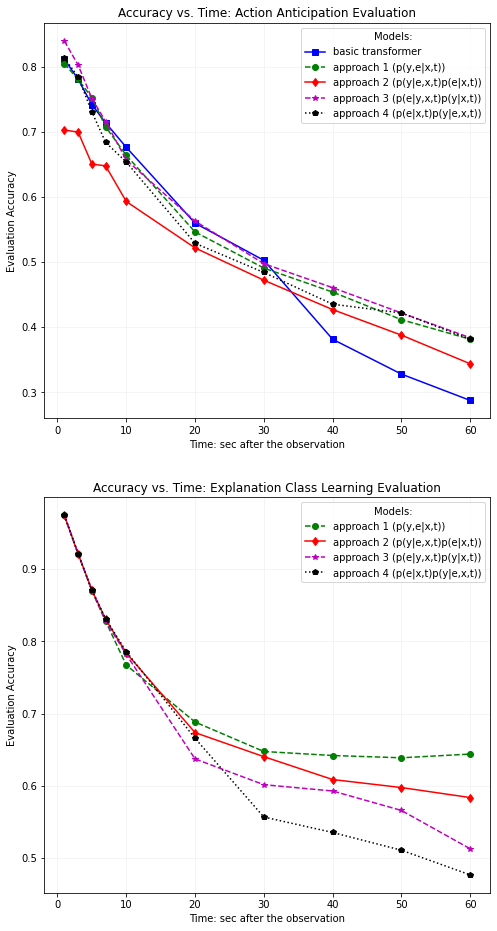

In [86]:
plt.subplot(211)
plt.plot(ts, acc_basic, 's-b', label="basic transformer")
plt.plot(ts, acc_a_appr1, 'o--g', label="approach 1 (p(y,e|x,t))")
plt.plot(ts, acc_a_appr2, 'd-r', label="approach 2 (p(y|e,x,t)p(e|x,t))")
plt.plot(ts, acc_a_appr3, '*--m', label="approach 3 (p(e|y,x,t)p(y|x,t))")
plt.plot(ts, acc_a_appr4, 'p:k', label="approach 4 (p(e|x,t)p(y|e,x,t))")
plt.grid(color='0.95')
plt.legend(title='Models:')
plt.title('Accuracy vs. Time: Action Anticipation Evaluation')
plt.xlabel("Time: sec after the observation")
plt.ylabel("Evaluation Accuracy")

plt.subplot(212)
plt.plot(ts, acc_e_appr1, 'o--g', label="approach 1 (p(y,e|x,t))")
plt.plot(ts, acc_e_appr2, 'd-r', label="approach 2 (p(y|e,x,t)p(e|x,t))")
plt.plot(ts, acc_e_appr3, '*--m', label="approach 3 (p(e|y,x,t)p(y|x,t))")
plt.plot(ts, acc_e_appr4, 'p:k', label="approach 4 (p(e|x,t)p(y|e,x,t))")
plt.grid(color='0.95')
plt.legend(title='Models:')
plt.title('Accuracy vs. Time: Explanation Class Learning Evaluation')
plt.xlabel("Time: sec after the observation")
plt.ylabel("Evaluation Accuracy")

plt.gcf().set_size_inches(8, 16)
plt.show()

## 6. Other Models: TCN/LSTM

### Basic LSTM

In [98]:
class BasicLSTM(tf.keras.Model):
  """
  """
  def __init__(self, action_embed_dim, time_embed_dim, time_size, action_size):
    super(BasicLSTM, self).__init__()
    self.d_model = action_embed_dim + time_embed_dim
    self.num_layers = num_layers
    
    self.action_embedding = tf.keras.layers.Embedding(action_size, action_embed_dim)
    self.time_embedding = tf.keras.layers.Embedding(time_size, time_embed_dim)
    self.lstm_layer = tf.keras.layers.LSTM(d_model)
    self.final_layer = tf.keras.layers.Dense(action_size, activation="softmax")

  def call(self, x):
    x, t = x[:, :-1], x[:, -1]
    # (x.shape, t.shape) = ((batch_size, timesteps), (batch_size, ))
    ut = self.time_embedding(t)  
    ut = tf.repeat(ut[:, np.newaxis, :], x.shape[1], axis=1)

    x = self.action_embedding(x)  
    x = tf.concat([x, ut], axis=2)     # (batch_size, timesteps, d_model)
    
    x = self.lstm_layer(x)

    action_prob = self.final_layer(x)
    return action_prob

In [95]:
d_model = 128
time_embed_dim = 4
action_embed_dim = d_model - time_embed_dim
time_size = 61
action_size = 48

In [96]:
learning_rate = 1e-3
EPOCHS = 10
#optimizer = tf.optimizers.Adam(learning_rate, decay=learning_rate/EPOCHS)
optimizer = tf.optimizers.Adam(learning_rate)

In [90]:
def fitting_validation_dataset(dataset):
  input_lst, target_lst = [], []
  for x in iter(dataset):
    inputs, action_gts = x[0], x[1]
    batch_size = inputs.shape[0]
    for bs in range(batch_size):
      imax = 1
      while imax < 10 and action_gts[bs, imax].numpy() > 0:
        imax += 1
      i = np.random.randint(imax)
      input = np.append(inputs[bs, :].numpy(), ts[i])  # [x, t]
      target = np.zeros(action_size, dtype=int)
      target[action_gts[bs, i].numpy()] = 1  # one-hot code of the action
      input_lst.append(input)
      target_lst.append(target)
  res_set = tf.data.Dataset.from_tensor_slices((input_lst, target_lst))
  return res_set.padded_batch(BATCH_SIZE)

In [91]:
new_train_ds = [fitting_validation_dataset(train_dataset[s]) for s in range(4)]

In [ ]:
history = [None for _ in range(4)]
for s in range(4):
  print("------------------------------------------------------")
  print("Take s"+str(s+1)+" dataset as the testing set and concatenate the other 3 for training.\n")
  test_set = new_train_ds[s]
  tr_is = list(set(range(4)) - {s})
  training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
  basiclstm = BasicLSTM(action_embed_dim, time_embed_dim, time_size, action_size)
  optimizer = tf.optimizers.Adam(learning_rate)
  basiclstm.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
  history[s] = basiclstm.fit(x=training_set, validation_data=test_set, epochs=EPOCHS)

In [99]:
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
basiclstm = BasicLSTM(action_embed_dim, time_embed_dim, time_size, action_size)
optimizer = tf.optimizers.Adam(learning_rate)
basiclstm.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint_path = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/basiclstm/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
basiclstm.save_weights(checkpoint_path.format(epoch=0))
basiclstm.fit(x=training_set, validation_data=test_set, epochs=EPOCHS, callbacks=[cp_callback])

Epoch 1/10
243/243 [==============================] - 22s 83ms/step - loss: 2.0586 - accuracy: 0.5222 - val_loss: 0.9740 - val_accuracy: 0.7118

Epoch 00001: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/basiclstm/cp-0001.ckpt
Epoch 2/10
243/243 [==============================] - 19s 80ms/step - loss: 0.8914 - accuracy: 0.7202 - val_loss: 0.8703 - val_accuracy: 0.7502

Epoch 00002: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/basiclstm/cp-0002.ckpt
Epoch 3/10
243/243 [==============================] - 20s 81ms/step - loss: 0.7743 - accuracy: 0.7507 - val_loss: 0.8130 - val_accuracy: 0.7648

Epoch 00003: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/basiclstm/cp-0003.ckpt
Epoch 4/10
243/243 [==============================] - 20s 81ms/step - loss: 0.7231 - accuracy: 0.7666 - val_loss: 0.7979 - val_accuracy: 0.7633

Epoch 00004: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpo

In [100]:
loss, acc = basiclstm.evaluate(test_set, verbose=2)
print("Trained model, accuracy: {:5.2f}%".format(100 * acc))

40/40 - 1s - loss: 0.7843 - accuracy: 0.7648
Trained model, accuracy: 76.48%


In [ ]:
# Loads the weights
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
basiclstm = BasicLSTM(action_embed_dim, time_embed_dim, time_size, action_size)
optimizer = tf.optimizers.Adam(learning_rate)
basiclstm.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
basiclstm.build(next(iter(training_set))[0].shape)
checkpoint_dir = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/basiclstm"
basiclstm.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

evaluate

In [101]:
def predict_basiclstm(model, feature_vec, t_lst):
  res = []
  for t in t_lst:
    x = tf.constant(np.append(feature_vec, t))[np.newaxis, :]
    prob = model.predict(x)[0]
    code = np.argmax(prob)
    res.append(code)
  
  return res

In [102]:
evaluate_df_basiclstm = {t:[] for t in ts}

batch_n = len(train_dataset[0])
counter = 0

# test set: s1 = train_dataset[0]
for obs_feature, tar_action, expl_type, expl in train_dataset[0]:
  start = time.time()
  counter += 1
  print("Start: "+str(counter)+"/"+str(batch_n))
  samp_n = obs_feature.shape[0]
  for i in range(samp_n):
    feature_vec = obs_feature[i, :].numpy()
    tar_action_codes = tar_action[i, :].numpy()
    res = predict_basiclstm(basiclstm, feature_vec, ts)
    for j in range(len(ts)):
      action_code = res[j]
      evaluate_df_basiclstm[ts[j]].append(int(tar_action_codes[j]==action_code))
  n = len(evaluate_df_basiclstm[1])
  print(n, "time: ", time.time()-start)
  acc_basiclstm = [np.sum(evaluate_df_basiclstm[t])/n for t in ts]
  print("Accuracy: ", acc_basiclstm)

Start: 1/40
64 time:  28.390849590301514
Accuracy:  [0.953125, 0.90625, 0.890625, 0.828125, 0.75, 0.65625, 0.53125, 0.5, 0.421875, 0.40625]
Start: 2/40
128 time:  27.827183723449707
Accuracy:  [0.953125, 0.8828125, 0.8515625, 0.78125, 0.7421875, 0.640625, 0.5625, 0.5234375, 0.4296875, 0.3984375]
Start: 3/40
192 time:  28.293296813964844
Accuracy:  [0.9322916666666666, 0.8697916666666666, 0.8489583333333334, 0.7916666666666666, 0.75, 0.6041666666666666, 0.53125, 0.5, 0.4322916666666667, 0.40625]
Start: 4/40
256 time:  28.176069259643555
Accuracy:  [0.9296875, 0.87890625, 0.8515625, 0.796875, 0.75, 0.61328125, 0.51953125, 0.47265625, 0.42578125, 0.39453125]
Start: 5/40
320 time:  28.63289523124695
Accuracy:  [0.928125, 0.86875, 0.84375, 0.8, 0.75, 0.609375, 0.525, 0.5, 0.453125, 0.421875]
Start: 6/40
384 time:  28.012277126312256
Accuracy:  [0.9166666666666666, 0.859375, 0.828125, 0.7890625, 0.7447916666666666, 0.6067708333333334, 0.53125, 0.5078125, 0.4635416666666667, 0.432291666666666

In [103]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/evaluate_df_basiclstm.pickle", 'wb') as pf:
  pickle.dump(evaluate_df_basiclstm, pf, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/evaluate_df_basiclstm.pickle", 'rb') as pf:
  evaluate_df_basiclstm = pickle.load(pf)

In [104]:
n = len(evaluate_df_basiclstm[1])
acc_basiclstm = [np.sum(evaluate_df_basiclstm[t])/n for t in ts]
print("Accuracy: ", acc_basiclstm)

Accuracy:  [0.9121140142517815, 0.8555027711797308, 0.7992874109263658, 0.7513855898653998, 0.7106096595407759, 0.5870942201108472, 0.5237529691211401, 0.47268408551068886, 0.4259699129057799, 0.3824228028503563]


In [105]:
acc_a_pd = pd.DataFrame(np.round(np.array([acc_basic, acc_basiclstm, acc_a_appr1, acc_a_appr2, acc_a_appr3, acc_a_appr4]), decimals=4), index=["Basic Transformer", "Basic LSTM", "Approach1", "Approach2", "Approach3", "Approach4"], columns=["t="+str(t) for t in ts])
acc_a_pd.index.name = "Action Accuracy"
acc_a_pd

,t=1,t=3,t=5,t=7,t=10,t=20,t=30,t=40,t=50,t=60
Action Accuracy,,,,,,,,,,
Basic Transformer,0.8112,0.7807,0.7415,0.7138,0.6762,0.5598,0.5028,0.3816,0.3282,0.2878
Basic LSTM,0.9121,0.8555,0.7993,0.7514,0.7106,0.5871,0.5238,0.4727,0.4260,0.3824
Approach1,0.8044,0.7803,0.7526,0.7074,0.6639,0.5463,0.4909,0.4541,0.4117,0.3816
Approach2,0.7027,0.6995,0.6504,0.6477,0.5930,0.5218,0.4723,0.4272,0.3880,0.3440
Approach3,0.8393,0.8025,0.7510,0.7158,0.6568,0.5629,0.4976,0.4608,0.4220,0.3840
Approach4,0.8131,0.7842,0.7304,0.6837,0.6536,0.5289,0.4842,0.4355,0.4220,0.3816


In [106]:
acc_e_pd = pd.DataFrame(np.round(np.array([acc_e_appr1, acc_e_appr2, acc_e_appr3, acc_e_appr4]), decimals=4), index=["Approach1", "Approach2", "Approach3", "Approach4"], columns=["t="+str(t) for t in ts])
acc_e_pd.index.name = "Explanation Class Accuracy"
acc_e_pd

,t=1,t=3,t=5,t=7,t=10,t=20,t=30,t=40,t=50,t=60
Explanation Class Accuracy,,,,,,,,,,
Approach1,0.9743,0.9212,0.8698,0.8278,0.7672,0.6884,0.6477,0.6421,0.6390,0.6441
Approach2,0.9743,0.9212,0.8709,0.8306,0.7838,0.6738,0.6405,0.6089,0.5978,0.5839
Approach3,0.9743,0.9212,0.8709,0.8282,0.7819,0.6374,0.6017,0.5930,0.5661,0.5131
Approach4,0.9743,0.9212,0.8709,0.8314,0.7858,0.6659,0.5570,0.5356,0.5111,0.4770


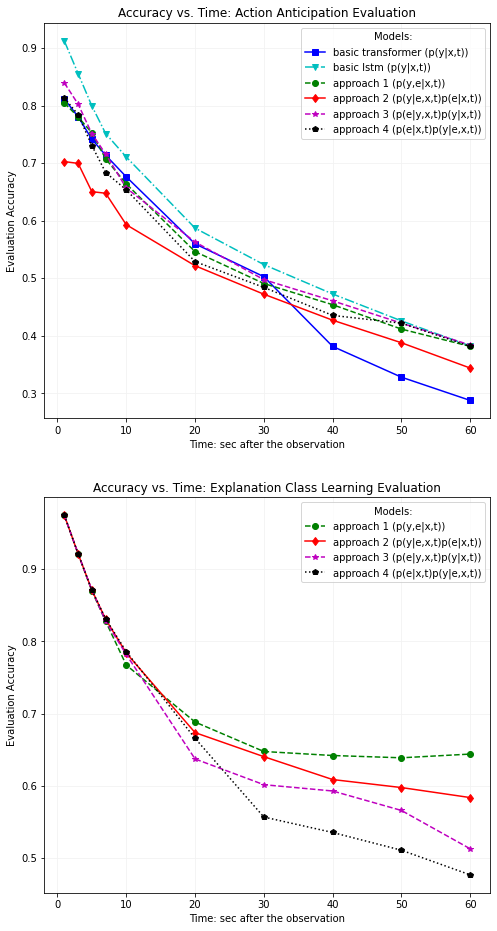

In [107]:
plt.subplot(211)
plt.plot(ts, acc_basic, 's-b', label="basic transformer (p(y|x,t))")
plt.plot(ts, acc_basiclstm, 'v-.c', label="basic lstm (p(y|x,t))")
plt.plot(ts, acc_a_appr1, 'o--g', label="approach 1 (p(y,e|x,t))")
plt.plot(ts, acc_a_appr2, 'd-r', label="approach 2 (p(y|e,x,t)p(e|x,t))")
plt.plot(ts, acc_a_appr3, '*--m', label="approach 3 (p(e|y,x,t)p(y|x,t))")
plt.plot(ts, acc_a_appr4, 'p:k', label="approach 4 (p(e|x,t)p(y|e,x,t))")
plt.grid(color='0.95')
plt.legend(title='Models:')
plt.title('Accuracy vs. Time: Action Anticipation Evaluation')
plt.xlabel("Time: sec after the observation")
plt.ylabel("Evaluation Accuracy")

plt.subplot(212)
plt.plot(ts, acc_e_appr1, 'o--g', label="approach 1 (p(y,e|x,t))")
plt.plot(ts, acc_e_appr2, 'd-r', label="approach 2 (p(y|e,x,t)p(e|x,t))")
plt.plot(ts, acc_e_appr3, '*--m', label="approach 3 (p(e|y,x,t)p(y|x,t))")
plt.plot(ts, acc_e_appr4, 'p:k', label="approach 4 (p(e|x,t)p(y|e,x,t))")
plt.grid(color='0.95')
plt.legend(title='Models:')
plt.title('Accuracy vs. Time: Explanation Class Learning Evaluation')
plt.xlabel("Time: sec after the observation")
plt.ylabel("Evaluation Accuracy")

plt.gcf().set_size_inches(8, 16)
plt.show()

### Basic TCN

#### Layer
source: [github](https://github.com/philipperemy/keras-tcn/blob/master/tcn/tcn.py)


In [108]:
import inspect
from typing import List

from tensorflow.keras import backend as K, Model, Input, optimizers
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, SpatialDropout1D, Lambda
from tensorflow.keras.layers import Layer, Conv1D, Dense, BatchNormalization, LayerNormalization


def is_power_of_two(num: int):
    return num != 0 and ((num & (num - 1)) == 0)


def adjust_dilations(dilations: list):
    if all([is_power_of_two(i) for i in dilations]):
        return dilations
    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations


class ResidualBlock(Layer):

    def __init__(self,
                 dilation_rate: int,
                 nb_filters: int,
                 kernel_size: int,
                 padding: str,
                 activation: str = 'relu',
                 dropout_rate: float = 0,
                 kernel_initializer: str = 'he_normal',
                 use_batch_norm: bool = False,
                 use_layer_norm: bool = False,
                 use_weight_norm: bool = False,
                 **kwargs):
        """Defines the residual block for the WaveNet TCN
        Args:
            x: The previous layer in the model
            training: boolean indicating whether the layer should behave in training mode or in inference mode
            dilation_rate: The dilation power of 2 we are using for this residual block
            nb_filters: The number of convolutional filters to use in this block
            kernel_size: The size of the convolutional kernel
            padding: The padding used in the convolutional layers, 'same' or 'causal'.
            activation: The final activation used in o = Activation(x + F(x))
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
            use_batch_norm: Whether to use batch normalization in the residual layers or not.
            use_layer_norm: Whether to use layer normalization in the residual layers or not.
            use_weight_norm: Whether to use weight normalization in the residual layers or not.
            kwargs: Any initializers for Layer class.
        """

        self.dilation_rate = dilation_rate
        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.use_weight_norm = use_weight_norm
        self.kernel_initializer = kernel_initializer
        self.layers = []
        self.layers_outputs = []
        self.shape_match_conv = None
        self.res_output_shape = None
        self.final_activation = None

        super(ResidualBlock, self).__init__(**kwargs)

    def _build_layer(self, layer):
        """Helper function for building layer
        Args:
            layer: Appends layer to internal layer list and builds it based on the current output
                   shape of ResidualBlocK. Updates current output shape.
        """
        self.layers.append(layer)
        self.layers[-1].build(self.res_output_shape)
        self.res_output_shape = self.layers[-1].compute_output_shape(self.res_output_shape)

    def build(self, input_shape):

        with K.name_scope(self.name):  # name scope used to make sure weights get unique names
            self.layers = []
            self.res_output_shape = input_shape

            for k in range(2):
                name = 'conv1D_{}'.format(k)
                with K.name_scope(name):  # name scope used to make sure weights get unique names
                    conv = Conv1D(
                        filters=self.nb_filters,
                        kernel_size=self.kernel_size,
                        dilation_rate=self.dilation_rate,
                        padding=self.padding,
                        name=name,
                        kernel_initializer=self.kernel_initializer
                    )
                    if self.use_weight_norm:
                        from tensorflow_addons.layers import WeightNormalization
                        # wrap it. WeightNormalization API is different than BatchNormalization or LayerNormalization.
                        with K.name_scope('norm_{}'.format(k)):
                            conv = WeightNormalization(conv)
                    self._build_layer(conv)

                with K.name_scope('norm_{}'.format(k)):
                    if self.use_batch_norm:
                        self._build_layer(BatchNormalization())
                    elif self.use_layer_norm:
                        self._build_layer(LayerNormalization())
                    elif self.use_weight_norm:
                        pass  # done above.

                self._build_layer(Activation(self.activation))
                self._build_layer(SpatialDropout1D(rate=self.dropout_rate))

            if self.nb_filters != input_shape[-1]:
                # 1x1 conv to match the shapes (channel dimension).
                name = 'matching_conv1D'
                with K.name_scope(name):
                    # make and build this layer separately because it directly uses input_shape
                    self.shape_match_conv = Conv1D(filters=self.nb_filters,
                                                   kernel_size=1,
                                                   padding='same',
                                                   name=name,
                                                   kernel_initializer=self.kernel_initializer)
            else:
                name = 'matching_identity'
                self.shape_match_conv = Lambda(lambda x: x, name=name)

            with K.name_scope(name):
                self.shape_match_conv.build(input_shape)
                self.res_output_shape = self.shape_match_conv.compute_output_shape(input_shape)

            self._build_layer(Activation(self.activation))
            self.final_activation = Activation(self.activation)
            self.final_activation.build(self.res_output_shape)  # probably isn't necessary

            # this is done to force Keras to add the layers in the list to self._layers
            for layer in self.layers:
                self.__setattr__(layer.name, layer)
            self.__setattr__(self.shape_match_conv.name, self.shape_match_conv)
            self.__setattr__(self.final_activation.name, self.final_activation)

            super(ResidualBlock, self).build(input_shape)  # done to make sure self.built is set True

    def call(self, inputs, training=None):
        """
        Returns: A tuple where the first element is the residual model tensor, and the second
                 is the skip connection tensor.
        """
        x = inputs
        self.layers_outputs = [x]
        for layer in self.layers:
            training_flag = 'training' in dict(inspect.signature(layer.call).parameters)
            x = layer(x, training=training) if training_flag else layer(x)
            self.layers_outputs.append(x)
        x2 = self.shape_match_conv(inputs)
        self.layers_outputs.append(x2)
        res_x = layers.add([x2, x])
        self.layers_outputs.append(res_x)

        res_act_x = self.final_activation(res_x)
        self.layers_outputs.append(res_act_x)
        return [res_act_x, x]

    def compute_output_shape(self, input_shape):
        return [self.res_output_shape, self.res_output_shape]


class TCN(Layer):
    """Creates a TCN layer.
        Input shape:
            A tensor of shape (batch_size, timesteps, input_dim).
        Args:
            nb_filters: The number of filters to use in the convolutional layers. Can be a list.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual blocK.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            activation: The activation used in the residual blocks o = Activation(x + F(x)).
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
            use_batch_norm: Whether to use batch normalization in the residual layers or not.
            kwargs: Any other arguments for configuring parent class Layer. For example "name=str", Name of the model.
                    Use unique names when using multiple TCN.
        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=(1, 2, 4, 8, 16, 32),
                 padding='causal',
                 use_skip_connections=False,
                 dropout_rate=0.0,
                 return_sequences=False,
                 activation='relu',
                 kernel_initializer='he_normal',
                 use_batch_norm=False,
                 use_layer_norm=False,
                 use_weight_norm=False,
                 **kwargs):

        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.activation = activation
        self.padding = padding
        self.kernel_initializer = kernel_initializer
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.use_weight_norm = use_weight_norm
        self.skip_connections = []
        self.residual_blocks = []
        self.layers_outputs = []
        self.build_output_shape = None
        self.slicer_layer = None  # in case return_sequence=False
        self.output_slice_index = None  # in case return_sequence=False
        self.padding_same_and_time_dim_unknown = False  # edge case if padding='same' and time_dim = None

        if self.use_batch_norm + self.use_layer_norm + self.use_weight_norm > 1:
            raise ValueError('Only one normalization can be specified at once.')

        if isinstance(self.nb_filters, list):
            assert len(self.nb_filters) == len(self.dilations)

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")

        # initialize parent class
        super(TCN, self).__init__(**kwargs)

    @property
    def receptive_field(self):
        assert_msg = 'The receptive field formula works only with power of two dilations.'
        assert all([is_power_of_two(i) for i in self.dilations]), assert_msg
        return self.kernel_size * self.nb_stacks * self.dilations[-1]

    def build(self, input_shape):

        # member to hold current output shape of the layer for building purposes
        self.build_output_shape = input_shape

        # list to hold all the member ResidualBlocks
        self.residual_blocks = []
        total_num_blocks = self.nb_stacks * len(self.dilations)
        if not self.use_skip_connections:
            total_num_blocks += 1  # cheap way to do a false case for below

        for s in range(self.nb_stacks):
            for i, d in enumerate(self.dilations):
                res_block_filters = self.nb_filters[i] if isinstance(self.nb_filters, list) else self.nb_filters
                self.residual_blocks.append(ResidualBlock(dilation_rate=d,
                                                          nb_filters=res_block_filters,
                                                          kernel_size=self.kernel_size,
                                                          padding=self.padding,
                                                          activation=self.activation,
                                                          dropout_rate=self.dropout_rate,
                                                          use_batch_norm=self.use_batch_norm,
                                                          use_layer_norm=self.use_layer_norm,
                                                          use_weight_norm=self.use_weight_norm,
                                                          kernel_initializer=self.kernel_initializer,
                                                          name='residual_block_{}'.format(len(self.residual_blocks))))
                # build newest residual block
                self.residual_blocks[-1].build(self.build_output_shape)
                self.build_output_shape = self.residual_blocks[-1].res_output_shape

        # this is done to force keras to add the layers in the list to self._layers
        for layer in self.residual_blocks:
            self.__setattr__(layer.name, layer)

        self.output_slice_index = None
        if self.padding == 'same':
            time = self.build_output_shape.as_list()[1]
            if time is not None:  # if time dimension is defined. e.g. shape = (bs, 500, input_dim).
                self.output_slice_index = int(self.build_output_shape.as_list()[1] / 2)
            else:
                # It will known at call time. c.f. self.call.
                self.padding_same_and_time_dim_unknown = True

        else:
            self.output_slice_index = -1  # causal case.
        self.slicer_layer = Lambda(lambda tt: tt[:, self.output_slice_index, :])

    def compute_output_shape(self, input_shape):
        """
        Overridden in case keras uses it somewhere... no idea. Just trying to avoid future errors.
        """
        if not self.built:
            self.build(input_shape)
        if not self.return_sequences:
            batch_size = self.build_output_shape[0]
            batch_size = batch_size.value if hasattr(batch_size, 'value') else batch_size
            nb_filters = self.build_output_shape[-1]
            return [batch_size, nb_filters]
        else:
            # Compatibility tensorflow 1.x
            return [v.value if hasattr(v, 'value') else v for v in self.build_output_shape]

    def call(self, inputs, training=None):
        x = inputs
        self.layers_outputs = [x]
        self.skip_connections = []
        for layer in self.residual_blocks:
            try:
                x, skip_out = layer(x, training=training)
            except TypeError:  # compatibility with tensorflow 1.x
                x, skip_out = layer(K.cast(x, 'float32'), training=training)
            self.skip_connections.append(skip_out)
            self.layers_outputs.append(x)

        if self.use_skip_connections:
            x = layers.add(self.skip_connections)
            self.layers_outputs.append(x)

        if not self.return_sequences:
            # case: time dimension is unknown. e.g. (bs, None, input_dim).
            if self.padding_same_and_time_dim_unknown:
                self.output_slice_index = K.shape(self.layers_outputs[-1])[1] // 2
            x = self.slicer_layer(x)
            self.layers_outputs.append(x)
        return x

    def get_config(self):
        """
        Returns the config of a the layer. This is used for saving and loading from a model
        :return: python dictionary with specs to rebuild layer
        """
        config = super(TCN, self).get_config()
        config['nb_filters'] = self.nb_filters
        config['kernel_size'] = self.kernel_size
        config['nb_stacks'] = self.nb_stacks
        config['dilations'] = self.dilations
        config['padding'] = self.padding
        config['use_skip_connections'] = self.use_skip_connections
        config['dropout_rate'] = self.dropout_rate
        config['return_sequences'] = self.return_sequences
        config['activation'] = self.activation
        config['use_batch_norm'] = self.use_batch_norm
        config['use_layer_norm'] = self.use_layer_norm
        config['use_weight_norm'] = self.use_weight_norm
        config['kernel_initializer'] = self.kernel_initializer
        return config


def compiled_tcn(num_feat,  # type: int
                 num_classes,  # type: int
                 nb_filters,  # type: int
                 kernel_size,  # type: int
                 dilations,  # type: List[int]
                 nb_stacks,  # type: int
                 max_len,  # type: int
                 output_len=1,  # type: int
                 padding='causal',  # type: str
                 use_skip_connections=False,  # type: bool
                 return_sequences=True,
                 regression=False,  # type: bool
                 dropout_rate=0.05,  # type: float
                 name='tcn',  # type: str,
                 kernel_initializer='he_normal',  # type: str,
                 activation='relu',  # type:str,
                 opt='adam',
                 lr=0.002,
                 use_batch_norm=False,
                 use_layer_norm=False,
                 use_weight_norm=False):
    # type: (...) -> Model
    """Creates a compiled TCN model for a given task (i.e. regression or classification).
    Classification uses a sparse categorical loss. Please input class ids and not one-hot encodings.
    Args:
        num_feat: The number of features of your input, i.e. the last dimension of: (batch_size, timesteps, input_dim).
        num_classes: The size of the final dense layer, how many classes we are predicting.
        nb_filters: The number of filters to use in the convolutional layers.
        kernel_size: The size of the kernel to use in each convolutional layer.
        dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
        nb_stacks : The number of stacks of residual blocks to use.
        max_len: The maximum sequence length, use None if the sequence length is dynamic.
        padding: The padding to use in the convolutional layers.
        use_skip_connections: Boolean. If we want to add skip connections from input to each residual blocK.
        return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
        regression: Whether the output should be continuous or discrete.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        activation: The activation used in the residual blocks o = Activation(x + F(x)).
        name: Name of the model. Useful when having multiple TCN.
        kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
        opt: Optimizer name.
        lr: Learning rate.
        use_batch_norm: Whether to use batch normalization in the residual layers or not.
        use_layer_norm: Whether to use layer normalization in the residual layers or not.
        use_weight_norm: Whether to use weight normalization in the residual layers or not.
    Returns:
        A compiled keras TCN.
    """

    dilations = adjust_dilations(dilations)

    input_layer = Input(shape=(max_len, num_feat))

    x = TCN(nb_filters, kernel_size, nb_stacks, dilations, padding,
            use_skip_connections, dropout_rate, return_sequences,
            activation, kernel_initializer, use_batch_norm, use_layer_norm,
            use_weight_norm, name=name)(input_layer)

    print('x.shape=', x.shape)

    def get_opt():
        if opt == 'adam':
            return optimizers.Adam(lr=lr, clipnorm=1.)
        elif opt == 'rmsprop':
            return optimizers.RMSprop(lr=lr, clipnorm=1.)
        else:
            raise Exception('Only Adam and RMSProp are available here')

    if not regression:
        # classification
        x = Dense(num_classes)(x)
        x = Activation('softmax')(x)
        output_layer = x
        model = Model(input_layer, output_layer)

        # https://github.com/keras-team/keras/pull/11373
        # It's now in Keras@master but still not available with pip.
        # TODO remove later.
        def accuracy(y_true, y_pred):
            # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
            if K.ndim(y_true) == K.ndim(y_pred):
                y_true = K.squeeze(y_true, -1)
            # convert dense predictions to labels
            y_pred_labels = K.argmax(y_pred, axis=-1)
            y_pred_labels = K.cast(y_pred_labels, K.floatx())
            return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

        model.compile(get_opt(), loss='sparse_categorical_crossentropy', metrics=[accuracy])
    else:
        # regression
        x = Dense(output_len)(x)
        x = Activation('linear')(x)
        output_layer = x
        model = Model(input_layer, output_layer)
        model.compile(get_opt(), loss='mean_squared_error')
    print('model.x = {}'.format(input_layer.shape))
    print('model.y = {}'.format(output_layer.shape))
    return model


def tcn_full_summary(model: Model, expand_residual_blocks=True):
    layers = model._layers.copy()  # store existing layers
    model._layers.clear()  # clear layers

    for i in range(len(layers)):
        if isinstance(layers[i], TCN):
            for layer in layers[i]._layers:
                if not isinstance(layer, ResidualBlock):
                    if not hasattr(layer, '__iter__'):
                        model._layers.append(layer)
                else:
                    if expand_residual_blocks:
                        for lyr in layer._layers:
                            if not hasattr(lyr, '__iter__'):
                                model._layers.append(lyr)
                    else:
                        model._layers.append(layer)
        else:
            model._layers.append(layers[i])

    model.summary()  # print summary

    # restore original layers
    model._layers.clear()
    [model._layers.append(lyr) for lyr in layers]

#### Model

In [118]:
class BasicTCN(tf.keras.Model):
  """
  """
  def __init__(self, action_embed_dim, time_embed_dim, time_size, action_size):
    super(BasicTCN, self).__init__()
    self.d_model = action_embed_dim + time_embed_dim
    self.num_layers = num_layers
    
    self.action_embedding = tf.keras.layers.Embedding(action_size, action_embed_dim)
    self.time_embedding = tf.keras.layers.Embedding(time_size, time_embed_dim)
    self.tcn_layer = TCN(d_model)
    self.final_layer = tf.keras.layers.Dense(action_size, activation="softmax")

  def call(self, x):
    x, t = x[:, :-1], x[:, -1]
    # (x.shape, t.shape) = ((batch_size, timesteps), (batch_size, ))
    ut = self.time_embedding(t)  
    ut = tf.repeat(ut[:, np.newaxis, :], x.shape[1], axis=1)

    x = self.action_embedding(x)  
    x = tf.concat([x, ut], axis=2)     # (batch_size, timesteps, d_model)

    x = self.tcn_layer(x)
    
    action_prob = self.final_layer(x)
    return action_prob

In [110]:
d_model = 128
time_embed_dim = 4
action_embed_dim = d_model - time_embed_dim
time_size = 61
action_size = 48

In [111]:
learning_rate = 1e-3
EPOCHS = 10
#optimizer = tf.optimizers.Adam(learning_rate, decay=learning_rate/EPOCHS)
optimizer = tf.optimizers.Adam(learning_rate)

In [112]:
def fitting_validation_dataset(dataset):
  input_lst, target_lst = [], []
  for x in iter(dataset):
    inputs, action_gts = x[0], x[1]
    batch_size = inputs.shape[0]
    for bs in range(batch_size):
      imax = 1
      while imax < 10 and action_gts[bs, imax].numpy() > 0:
        imax += 1
      i = np.random.randint(imax)
      input = np.append(inputs[bs, :].numpy(), ts[i])  # [x, t]
      target = np.zeros(action_size, dtype=int)
      target[action_gts[bs, i].numpy()] = 1  # one-hot code of the action
      input_lst.append(input)
      target_lst.append(target)
  res_set = tf.data.Dataset.from_tensor_slices((input_lst, target_lst))
  return res_set.padded_batch(BATCH_SIZE)

In [113]:
new_train_ds = [fitting_validation_dataset(train_dataset[s]) for s in range(4)]

In [ ]:
history = [None for _ in range(4)]
for s in range(4):
  print("------------------------------------------------------")
  print("Take s"+str(s+1)+" dataset as the testing set and concatenate the other 3 for training.\n")
  test_set = new_train_ds[s]
  tr_is = list(set(range(4)) - {s})
  training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
  basictcn = BasicTCN(action_embed_dim, time_embed_dim, time_size, action_size)
  optimizer = tf.optimizers.Adam(learning_rate)
  basictcn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
  history[s] = basictcn.fit(x=training_set, validation_data=test_set, epochs=EPOCHS)

In [119]:
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
basictcn = BasicTCN(action_embed_dim, time_embed_dim, time_size, action_size)
optimizer = tf.optimizers.Adam(learning_rate)
basictcn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint_path = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/basictcn/cp-{epoch:04d}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
basictcn.save_weights(checkpoint_path.format(epoch=0))
basictcn.fit(x=training_set, validation_data=test_set, epochs=EPOCHS, callbacks=[cp_callback])

Epoch 1/10
243/243 [==============================] - 60s 235ms/step - loss: 1.5067 - accuracy: 0.6059 - val_loss: 0.9383 - val_accuracy: 0.7344

Epoch 00001: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/basictcn/cp-0001.ckpt
Epoch 2/10
243/243 [==============================] - 57s 235ms/step - loss: 0.7907 - accuracy: 0.7465 - val_loss: 0.8723 - val_accuracy: 0.7546

Epoch 00002: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/basictcn/cp-0002.ckpt
Epoch 3/10
243/243 [==============================] - 56s 232ms/step - loss: 0.7098 - accuracy: 0.7644 - val_loss: 0.8511 - val_accuracy: 0.7621

Epoch 00003: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/basictcn/cp-0003.ckpt
Epoch 4/10
243/243 [==============================] - 56s 232ms/step - loss: 0.6707 - accuracy: 0.7754 - val_loss: 0.8398 - val_accuracy: 0.7565

Epoch 00004: saving model to /content/drive/MyDrive/FurtherStudy/Project2020/checkp

In [120]:
loss, acc = basictcn.evaluate(test_set, verbose=2)
print("Trained model, accuracy: {:5.2f}%".format(100 * acc))

40/40 - 2s - loss: 0.9087 - accuracy: 0.7478
Trained model, accuracy: 74.78%


In [ ]:
# Loads the weights
s = 0
test_set = new_train_ds[s]
tr_is = list(set(range(4)) - {s})
training_set = new_train_ds[tr_is[0]].concatenate(new_train_ds[tr_is[1]]).concatenate(new_train_ds[tr_is[2]])
basictcn = BasicTCN(action_embed_dim, time_embed_dim, time_size, action_size)
optimizer = tf.optimizers.Adam(learning_rate)
basictcn.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
basictcn.build(next(iter(training_set))[0].shape)
checkpoint_dir = "/content/drive/MyDrive/FurtherStudy/Project2020/checkpoints/basictcn"
basictcn.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

evaluate

In [121]:
def predict_basictcn(model, feature_vec, t_lst):
  res = []
  for t in t_lst:
    x = tf.constant(np.append(feature_vec, t))[np.newaxis, :]
    prob = model.predict(x)[0]
    code = np.argmax(prob)
    res.append(code)
  
  return res

In [122]:
evaluate_df_basictcn = {t:[] for t in ts}

batch_n = len(train_dataset[0])
counter = 0

# test set: s1 = train_dataset[0]
for obs_feature, tar_action, expl_type, expl in train_dataset[0]:
  start = time.time()
  counter += 1
  print("Start: "+str(counter)+"/"+str(batch_n))
  samp_n = obs_feature.shape[0]
  for i in range(samp_n):
    feature_vec = obs_feature[i, :].numpy()
    tar_action_codes = tar_action[i, :].numpy()
    res = predict_basictcn(basictcn, feature_vec, ts)
    for j in range(len(ts)):
      action_code = res[j]
      evaluate_df_basictcn[ts[j]].append(int(tar_action_codes[j]==action_code))
  n = len(evaluate_df_basictcn[1])
  print(n, "time: ", time.time()-start)
  acc_basictcn = [np.sum(evaluate_df_basictcn[t])/n for t in ts]
  print("Accuracy: ", acc_basictcn)

Start: 1/40
64 time:  26.316734790802002
Accuracy:  [0.953125, 0.84375, 0.78125, 0.765625, 0.734375, 0.6875, 0.546875, 0.53125, 0.4375, 0.390625]
Start: 2/40
128 time:  26.690558910369873
Accuracy:  [0.9375, 0.859375, 0.796875, 0.765625, 0.734375, 0.609375, 0.5546875, 0.453125, 0.421875, 0.390625]
Start: 3/40
192 time:  25.949286699295044
Accuracy:  [0.9270833333333334, 0.8697916666666666, 0.7760416666666666, 0.75, 0.71875, 0.5677083333333334, 0.5208333333333334, 0.4375, 0.4166666666666667, 0.3958333333333333]
Start: 4/40
256 time:  26.88661479949951
Accuracy:  [0.921875, 0.87890625, 0.796875, 0.765625, 0.73828125, 0.5703125, 0.5234375, 0.44140625, 0.421875, 0.40234375]
Start: 5/40
320 time:  26.391779899597168
Accuracy:  [0.9125, 0.8625, 0.784375, 0.740625, 0.709375, 0.553125, 0.50625, 0.428125, 0.40625, 0.3875]
Start: 6/40
384 time:  27.568553686141968
Accuracy:  [0.9114583333333334, 0.8567708333333334, 0.7838541666666666, 0.7447916666666666, 0.7135416666666666, 0.546875, 0.494791666

In [123]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/evaluate_df_basictcn.pickle", 'wb') as pf:
  pickle.dump(evaluate_df_basictcn, pf, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("/content/drive/MyDrive/FurtherStudy/Project2020/evaluate_df_basictcn.pickle", 'rb') as pf:
  evaluate_df_basictcn = pickle.load(pf)

In [124]:
n = len(evaluate_df_basictcn[1])
acc_basictcn = [np.sum(evaluate_df_basictcn[t])/n for t in ts]
print("Accuracy: ", acc_basictcn)

Accuracy:  [0.9030087094220111, 0.8515439429928741, 0.7814726840855107, 0.7395091053048297, 0.6955661124307205, 0.5665083135391924, 0.5055423594615994, 0.4493269992082344, 0.4081551860649248, 0.3681710213776722]


In [125]:
acc_a_pd = pd.DataFrame(np.round(np.array([acc_basic, acc_basiclstm, acc_basictcn, acc_a_appr1, acc_a_appr2, acc_a_appr3, acc_a_appr4]), decimals=4), index=["Basic Transformer", "Basic LSTM", "Basic TCN", "Approach1", "Approach2", "Approach3", "Approach4"], columns=["t="+str(t) for t in ts])
acc_a_pd.index.name = "Action Accuracy"
acc_a_pd

,t=1,t=3,t=5,t=7,t=10,t=20,t=30,t=40,t=50,t=60
Action Accuracy,,,,,,,,,,
Basic Transformer,0.8112,0.7807,0.7415,0.7138,0.6762,0.5598,0.5028,0.3816,0.3282,0.2878
Basic LSTM,0.9121,0.8555,0.7993,0.7514,0.7106,0.5871,0.5238,0.4727,0.4260,0.3824
Basic TCN,0.9030,0.8515,0.7815,0.7395,0.6956,0.5665,0.5055,0.4493,0.4082,0.3682
Approach1,0.8044,0.7803,0.7526,0.7074,0.6639,0.5463,0.4909,0.4541,0.4117,0.3816
Approach2,0.7027,0.6995,0.6504,0.6477,0.5930,0.5218,0.4723,0.4272,0.3880,0.3440
Approach3,0.8393,0.8025,0.7510,0.7158,0.6568,0.5629,0.4976,0.4608,0.4220,0.3840
Approach4,0.8131,0.7842,0.7304,0.6837,0.6536,0.5289,0.4842,0.4355,0.4220,0.3816


In [126]:
acc_e_pd = pd.DataFrame(np.round(np.array([acc_e_appr1, acc_e_appr2, acc_e_appr3, acc_e_appr4]), decimals=4), index=["Approach1", "Approach2", "Approach3", "Approach4"], columns=["t="+str(t) for t in ts])
acc_e_pd.index.name = "Explanation Class Accuracy"
acc_e_pd

,t=1,t=3,t=5,t=7,t=10,t=20,t=30,t=40,t=50,t=60
Explanation Class Accuracy,,,,,,,,,,
Approach1,0.9743,0.9212,0.8698,0.8278,0.7672,0.6884,0.6477,0.6421,0.6390,0.6441
Approach2,0.9743,0.9212,0.8709,0.8306,0.7838,0.6738,0.6405,0.6089,0.5978,0.5839
Approach3,0.9743,0.9212,0.8709,0.8282,0.7819,0.6374,0.6017,0.5930,0.5661,0.5131
Approach4,0.9743,0.9212,0.8709,0.8314,0.7858,0.6659,0.5570,0.5356,0.5111,0.4770


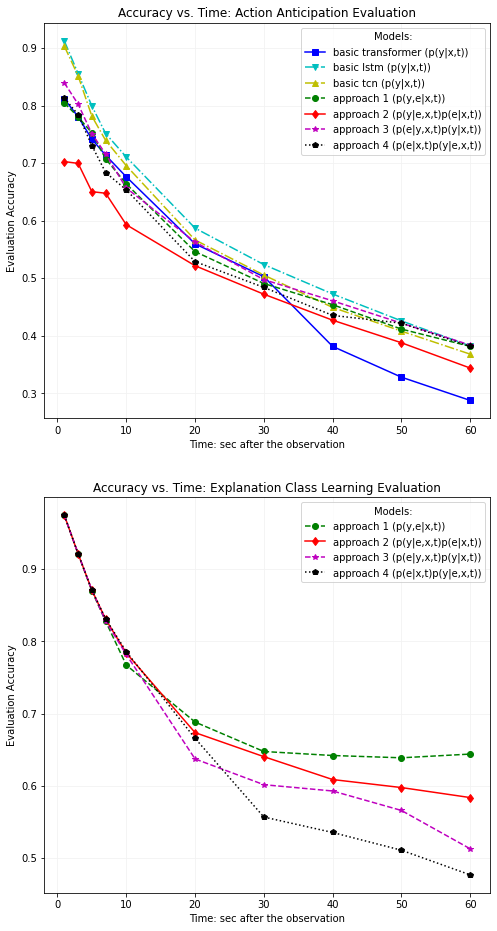

In [127]:
plt.subplot(211)
plt.plot(ts, acc_basic, 's-b', label="basic transformer (p(y|x,t))")
plt.plot(ts, acc_basiclstm, 'v-.c', label="basic lstm (p(y|x,t))")
plt.plot(ts, acc_basictcn, '^-.y', label="basic tcn (p(y|x,t))")
plt.plot(ts, acc_a_appr1, 'o--g', label="approach 1 (p(y,e|x,t))")
plt.plot(ts, acc_a_appr2, 'd-r', label="approach 2 (p(y|e,x,t)p(e|x,t))")
plt.plot(ts, acc_a_appr3, '*--m', label="approach 3 (p(e|y,x,t)p(y|x,t))")
plt.plot(ts, acc_a_appr4, 'p:k', label="approach 4 (p(e|x,t)p(y|e,x,t))")
plt.grid(color='0.95')
plt.legend(title='Models:')
plt.title('Accuracy vs. Time: Action Anticipation Evaluation')
plt.xlabel("Time: sec after the observation")
plt.ylabel("Evaluation Accuracy")

plt.subplot(212)
plt.plot(ts, acc_e_appr1, 'o--g', label="approach 1 (p(y,e|x,t))")
plt.plot(ts, acc_e_appr2, 'd-r', label="approach 2 (p(y|e,x,t)p(e|x,t))")
plt.plot(ts, acc_e_appr3, '*--m', label="approach 3 (p(e|y,x,t)p(y|x,t))")
plt.plot(ts, acc_e_appr4, 'p:k', label="approach 4 (p(e|x,t)p(y|e,x,t))")
plt.grid(color='0.95')
plt.legend(title='Models:')
plt.title('Accuracy vs. Time: Explanation Class Learning Evaluation')
plt.xlabel("Time: sec after the observation")
plt.ylabel("Evaluation Accuracy")

plt.gcf().set_size_inches(8, 16)
plt.show()

## 7. Other approaches
Try discriminative models

In [ ]:
next(iter(train_dataset[0]))[:3]
#np.zeros(action_size, dtype=np.int32)

(<tf.Tensor: shape=(64, 30), dtype=int64, numpy=
 array([[ 1,  1,  1, ..., 30, 30, 30],
        [ 7,  7,  7, ...,  7,  7,  7],
        [ 5,  5,  5, ...,  5,  5,  5],
        ...,
        [31, 31, 31, ..., 31, 31, 31],
        [19, 19, 19, ..., 19, 19, 19],
        [ 7,  7,  7, ...,  7,  7,  7]])>,
 <tf.Tensor: shape=(64, 10), dtype=int32, numpy=
 array([[30, 30, 30, 30, 30,  0,  0,  0,  0,  0],
        [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
        [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
        [17, 17, 17, 17,  0,  0,  0,  0,  0,  0],
        [ 5,  5,  5,  5,  5,  5,  5,  2,  0,  0],
        [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  2],
        [19, 19, 19, 19, 19, 19, 19, 19, 19, 46],
        [38, 38, 38, 38,  0,  0,  0,  0,  0,  0],
        [ 5,  5,  5,  5,  5,  5, 46,  0,  0,  0],
        [25, 25, 25, 25, 25, 25, 43,  0,  0,  0],
        [ 3, 38, 38, 38, 38,  0,  0,  0,  0,  0],
        [ 3,  3,  3,  3, 38,  3,  3, 38, 31, 31],
        [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
  